In [1]:
import pandas as pd
from os.path import join, isdir

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from icecream import ic
from src.utils import variant_utils as vu
from glob import glob
from itertools import product
from collections import defaultdict
from tqdm.notebook import tqdm

In [2]:
don_dir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/mt_clones_thresh/"
#samples = "preB,postB"
mt_genome="/data/Mito_Trace/data/external/GRCh38_MT_blacklist/chrM.fasta"
t=0.1
rt=25

## Parameters:
# af thresholds
# coverage threshold
# other_af thresholds
# number of cells / fraction cells
# number of other cells / fraction other cells
af_ts = [0.01, 0.1, 0.4, 0.8, 0.95]
oth_af_ts = [0.01, 0.1, 0.4, 0.8, 0.95]

cov_ts = [2, 5, 10, 30] # mean coverage at position for cells with the AF
oth_cov_ts = [2, 5, 10, 30]  # mean coverage for cells without AF 

num_cells = [5, 10, 0.1, 0.2, 0.5 ] # num cells and fraction are for cells with sufficient coverage
oth_num_cells = [0.25, 0.6, 0.8] # fraction is of cells with sufficient coverage

mean_pos_cov = [0, 2, 5, 10] #populatiion average coverage at that position

In [3]:
#samples = samples.split(",")

### Smaller params

In [4]:
af_ts = [0.01, 0.1, 0.4, 0.8,]
oth_af_ts = [0.01, 0.1, 0.4]

cov_ts = [2, 10, 30] # mean coverage at position for cells with the AF
oth_cov_ts = [2, 10, 30]  # mean coverage for cells without AF 

num_cells = [5, 10, 30] # num cells and fraction are for cells with sufficient coverage
oth_num_cells = [0.25, 0.6, 0.8] # fraction is of cells with sufficient coverage

mean_pos_cov = [0, 10] #populatiion average coverage at that position

In [5]:
don_dirs = [d for d in glob(don_dir + "/donor*") if isdir(d)]
don_dirs = {int(x.split("donor")[-1]):x for x in don_dirs}
#don_dirs = {x:don_dirs[x] for x in don_dirs if x in range(n_donors)}
don_dirs

{0: '/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor0',
 1: '/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor1'}

In [6]:
# thresholds = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9]
# read_thresh = [2, 10, 25, 50, 100]
# thresholds = [0.1, 0.25]#
# read_thresh = [25, 50]

# thresholds = [t]
# read_thresh=[rt]
# cells_thresh=10
# ref_cells_thresh=500

In [7]:
# There are 7 params to use for calling the clone
params = {"af":af_ts,
          "oth_af":oth_af_ts,
          "ncells": num_cells,
          "oth_ncells":oth_num_cells,
          "mean_cov": mean_pos_cov,
          "cov":cov_ts,
          "oth_cov":oth_cov_ts,
         }

full_params = list(product(*list(params.values())))
full_params = pd.DataFrame(full_params, columns=params.keys())
full_params.head()

,af,oth_af,ncells,oth_ncells,mean_cov,cov,oth_cov
0,0.01,0.01,5,0.25,0,2,2
1,0.01,0.01,5,0.25,0,2,10
2,0.01,0.01,5,0.25,0,2,30
3,0.01,0.01,5,0.25,0,10,2
4,0.01,0.01,5,0.25,0,10,10


In [8]:
full_params.shape

(1944, 7)

In [10]:
def load_donor(don_dir):
    vcf = pd.read_csv(join(don_dir, "cellSNP.base.vcf"), sep="\t")
    variants_meta = vcf[["#CHROM", "POS", "REF", "ALT"]]
    variants_meta.index = variants_meta.apply(lambda x: f"{x['POS']}{x['REF'][0]}>{x['ALT']}", axis=1)
    variants_meta = vu.type_of_variants(variants_meta.index)
    variants_meta["ID"] = variants_meta.index
    variants_meta.index = variants_meta.apply(lambda x: f"{x['position']}{x['alt']}", axis=1)
    af = pd.read_csv(join(don_dir, "af.tsv"), sep="\t", index_col=0)
    cov = pd.read_csv(join(don_dir, "dp.tsv"), sep="\t", index_col=0)                   
    cells_meta = pd.read_csv(join(don_dir,"cells_meta.tsv"), sep="\t").set_index("ID")
    ic(cells_meta.shape)
    cells_meta = cells_meta.loc[af.index]
    ic("After filtering on af indices", cells_meta.shape)
    
    variants = set(af.columns)
    return af, cov, cells_meta, variants



## Informative variants function
#af	oth_af	ncells	oth_ncells	mean_cov	cov	oth_cov
def get_vars(thresholds, position_af, position_cov):
    """ Sees if current position is an 'informative' variant using current thresholds
    """
    # preprocess some thresholds
    if thresholds["ncells"] < 1:
        ncells = int(np.floor(thresholds["ncells"] * len(position_af)))
    else:
        ncells = thresholds["ncells"]
    if thresholds["oth_ncells"] < 1:
        oth_ncells = int(np.floor(thresholds["oth_ncells"] * len(position_af)))
    else:
        oth_ncells = thresholds["oth_ncells"]    

    # Get cells that pass af and coverage thresholds
    bin_position_af_cov = (position_af > thresholds["af"]) & (position_cov > thresholds["cov"])
    #print('bin_pos', bin_position_af_cov)
    #print(bin_position_af_cov.sum())
    
    oth_bin_position_af_cov = (position_af <= thresholds["oth_af"]) & (position_cov > thresholds["oth_cov"])
    
    if (bin_position_af_cov.sum() > ncells) & (oth_bin_position_af_cov.sum() > oth_ncells):
        return True
    
    return False

def run_per_pos(af_cov, thresholds ,cov_id="COV-"):
    split = int(af_cov.shape[0]/2)
    af = af_cov.iloc[:split]
    cov = af_cov.iloc[split:]

    cov.index = [x.split(cov_id,1)[1] for x in cov.index]
    thresholds['isVar'] = thresholds.apply(get_vars, args=(af, cov), axis=1)
    thresholds["var"] = af_cov.name
    return thresholds


## Plot 
def plots(params_results, outdir, prefix):
    sns.histplot(params_results["n_vars"])

    cov_groups = params_results.groupby(["cov", "oth_cov", "mean_cov"])

    for ind, val in cov_groups:
        print(ind)
        sns.catplot(data=val, y="n_vars", x= "ncells", 
                    hue="af", row="oth_af", col="oth_ncells", kind="bar")
        plt.suptitle(f"{prefix} cov {ind[0]} oth_cov {ind[1]} mean_cov {ind[2]}")
        plt.tight_layout()
        plt.savefig(join(outdir,f"{prefix}_nvars_thresholds.cov_{ind[0]}_othcov_{ind[1]}_mean_{ind[2]}.png"))
    return

ic| cells_meta.shape: (9023, 6)
ic| 'After filtering on af indices', cells_meta.shape: (9023, 6)


0it [00:00, ?it/s]

(2, 2, 0)
(2, 2, 10)
(2, 10, 0)
(2, 10, 10)
(2, 30, 0)
(2, 30, 10)
(10, 2, 0)
(10, 2, 10)
(10, 10, 0)
(10, 10, 10)
(10, 30, 0)
(10, 30, 10)
(30, 2, 0)
(30, 2, 10)
(30, 10, 0)
(30, 10, 10)
(30, 30, 0)
(30, 30, 10)


ic| cells_meta.shape: (8275, 6)
ic| 'After filtering on af indices', cells_meta.shape: (8275, 6)


0it [00:00, ?it/s]

(2, 2, 0)
(2, 2, 10)


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


(2, 10, 0)
(2, 10, 10)
(2, 30, 0)
(2, 30, 10)
(10, 2, 0)
(10, 2, 10)
(10, 10, 0)
(10, 10, 10)
(10, 30, 0)
(10, 30, 10)
(30, 2, 0)
(30, 2, 10)
(30, 10, 0)
(30, 10, 10)
(30, 30, 0)
(30, 30, 10)


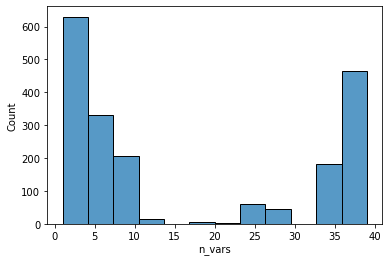

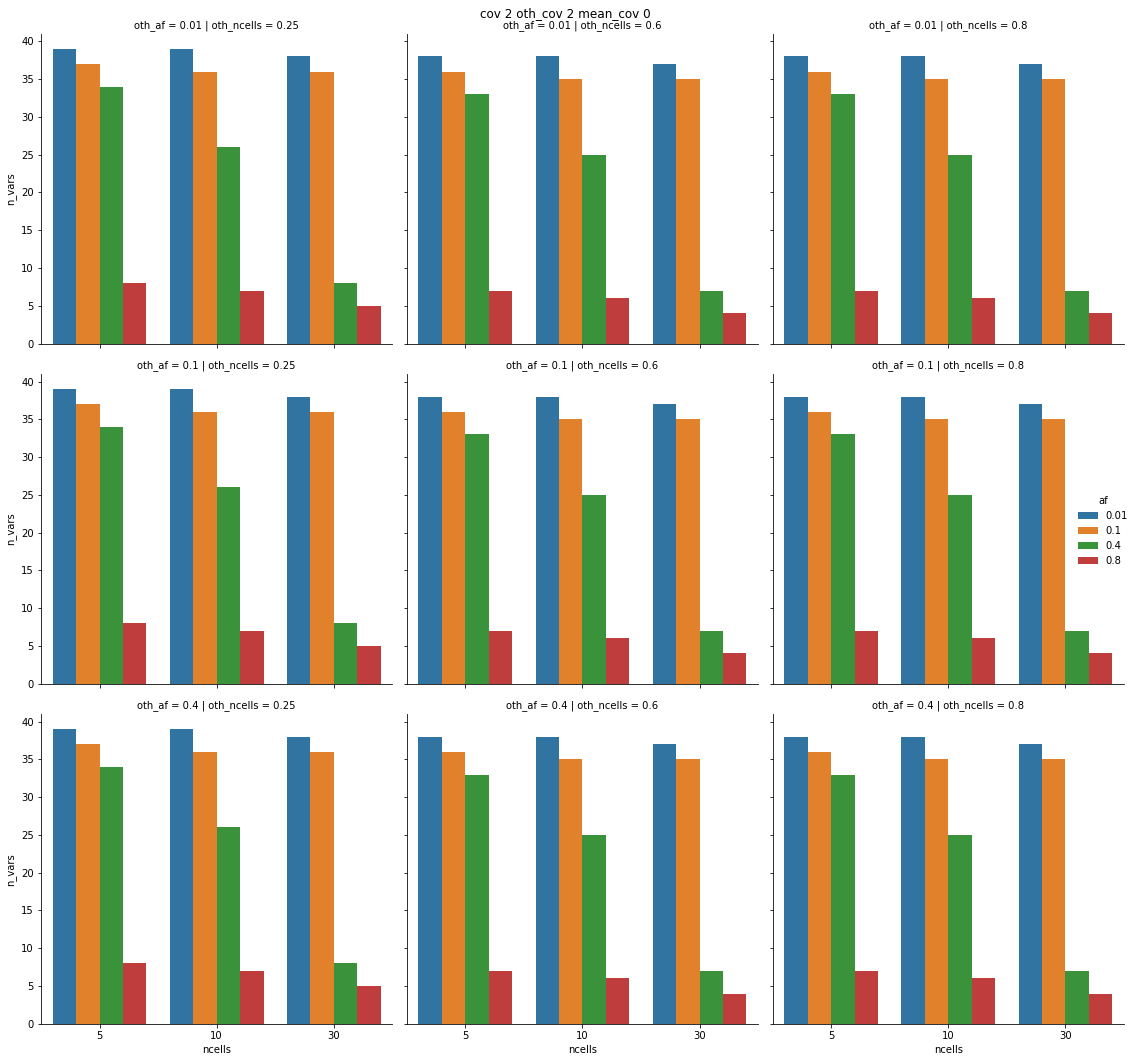

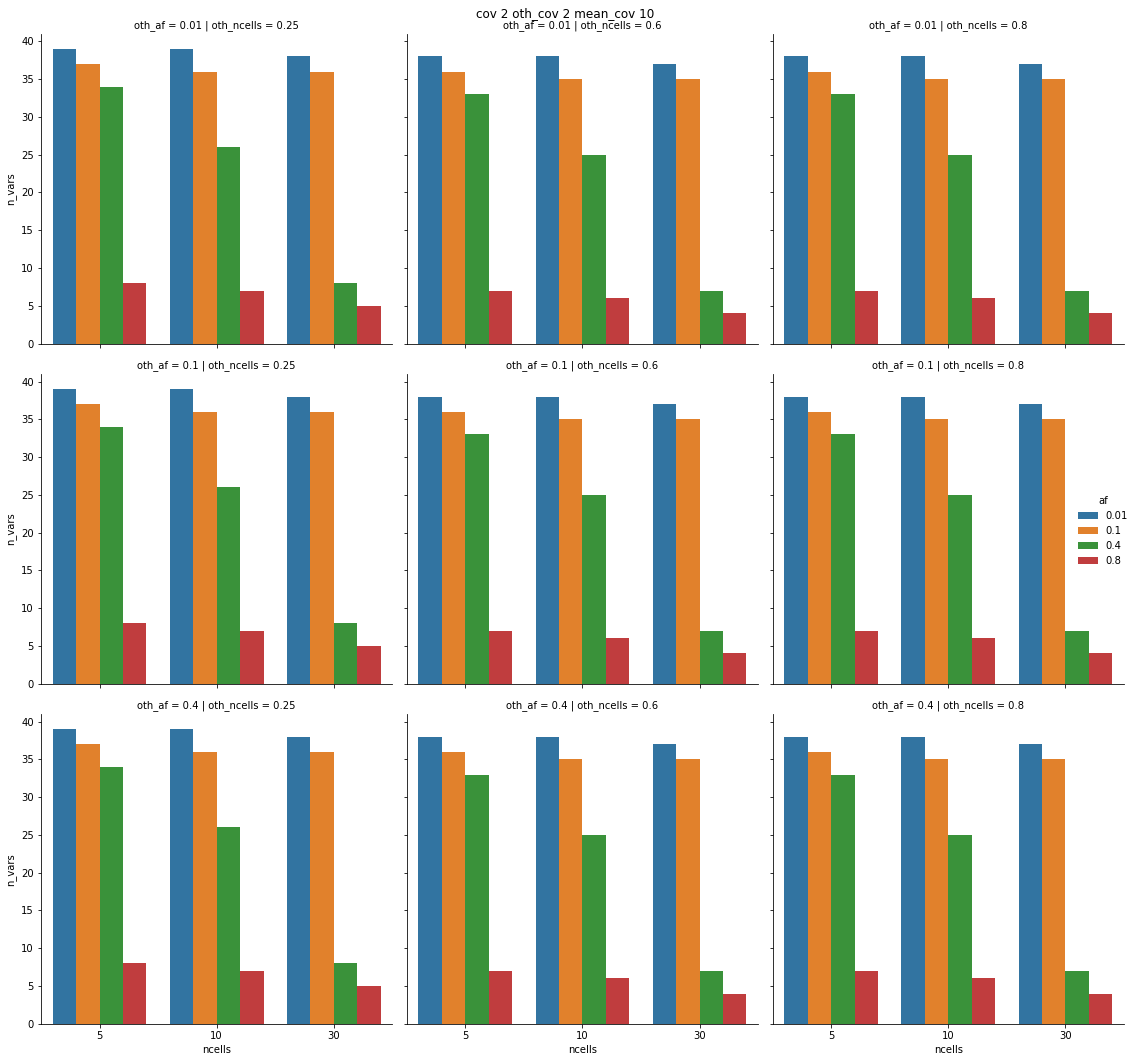

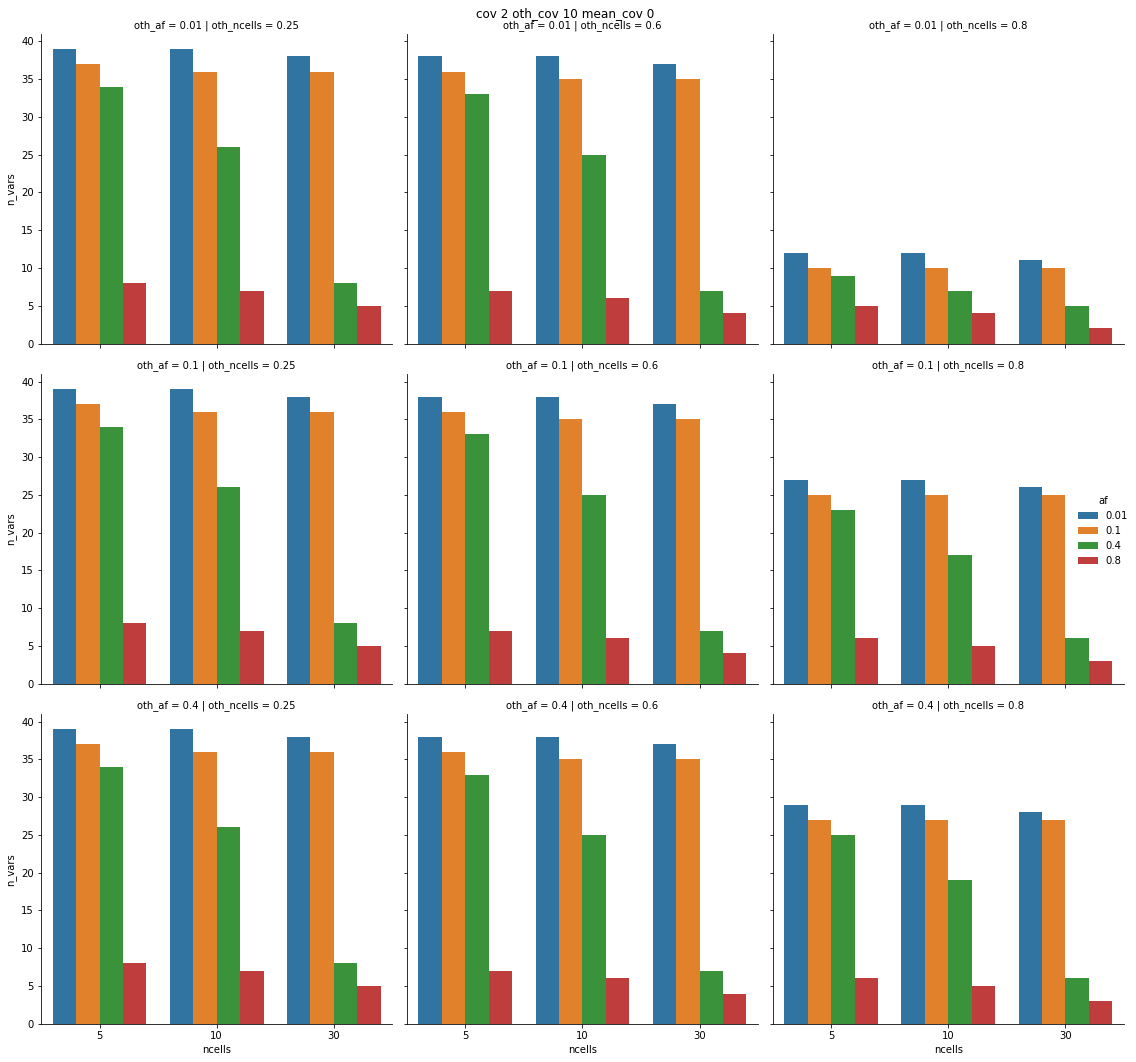

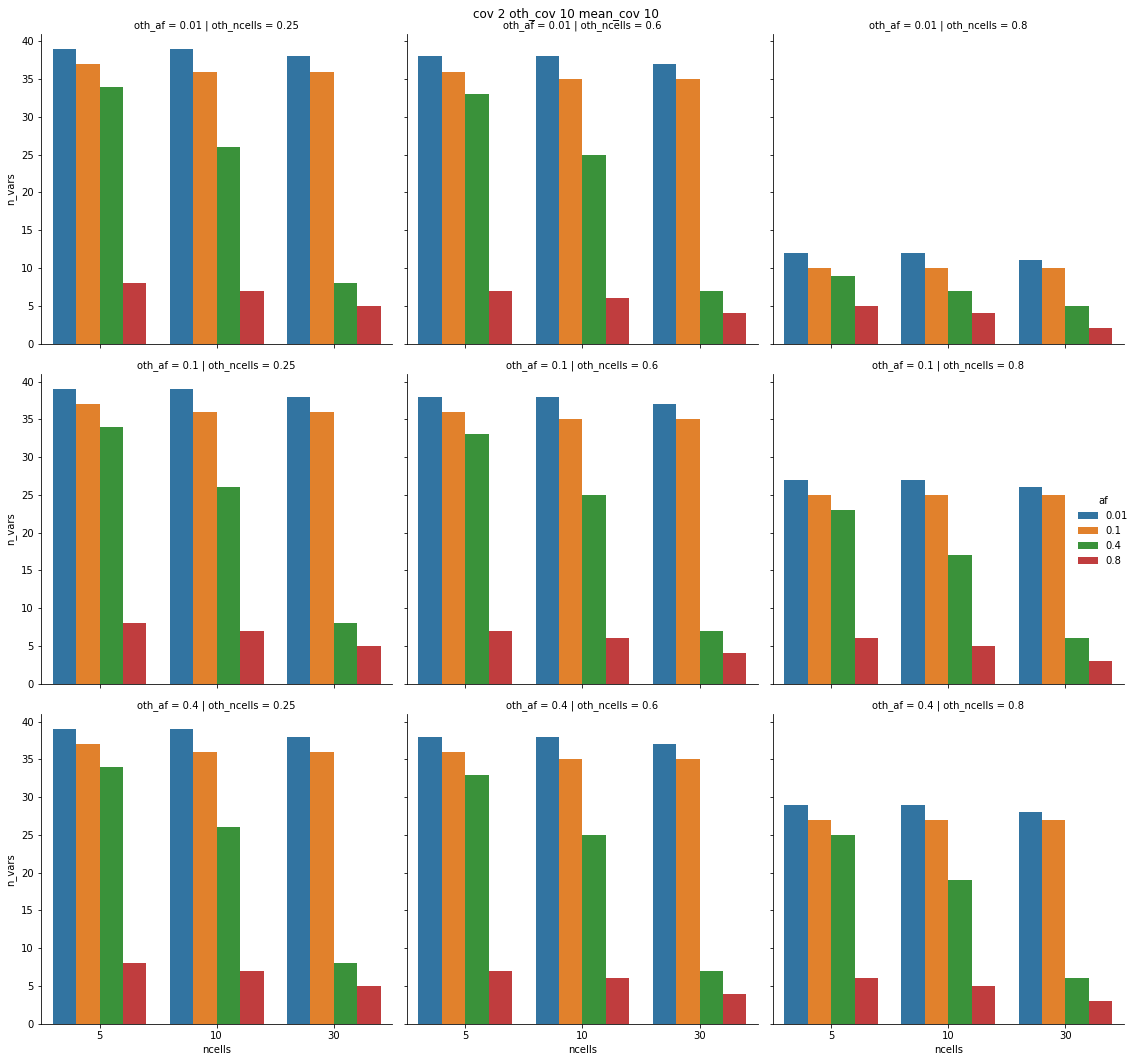

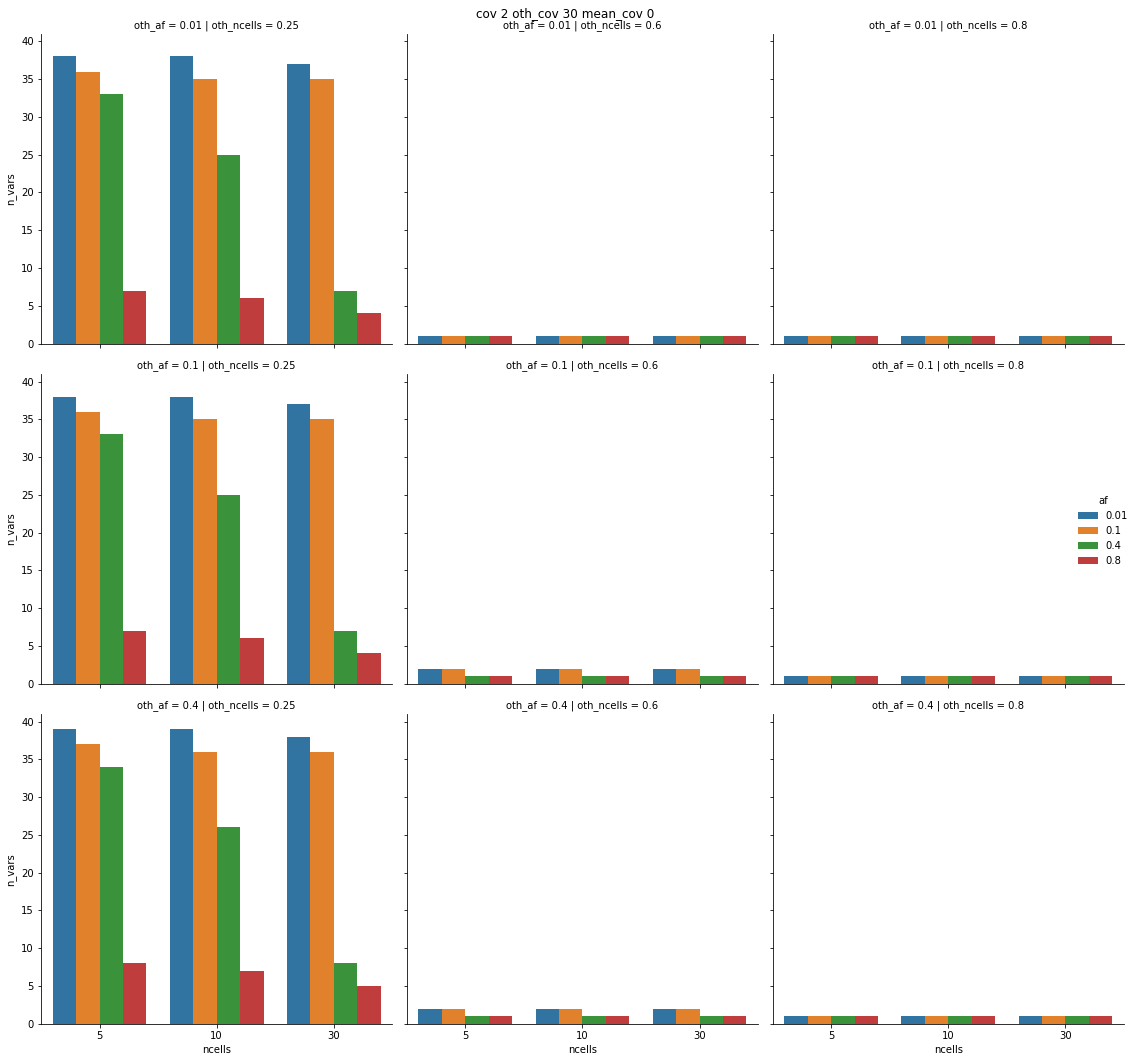

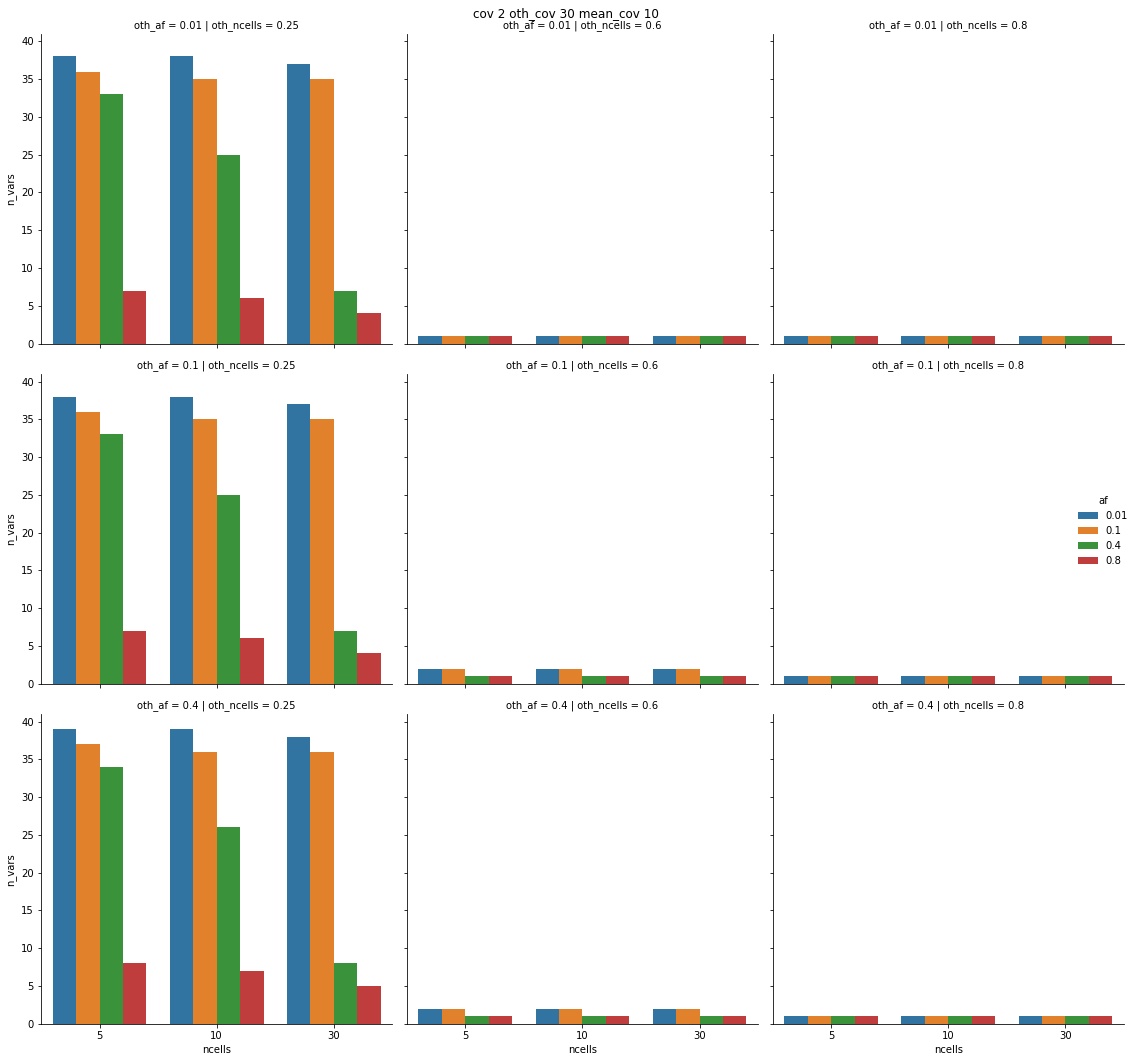

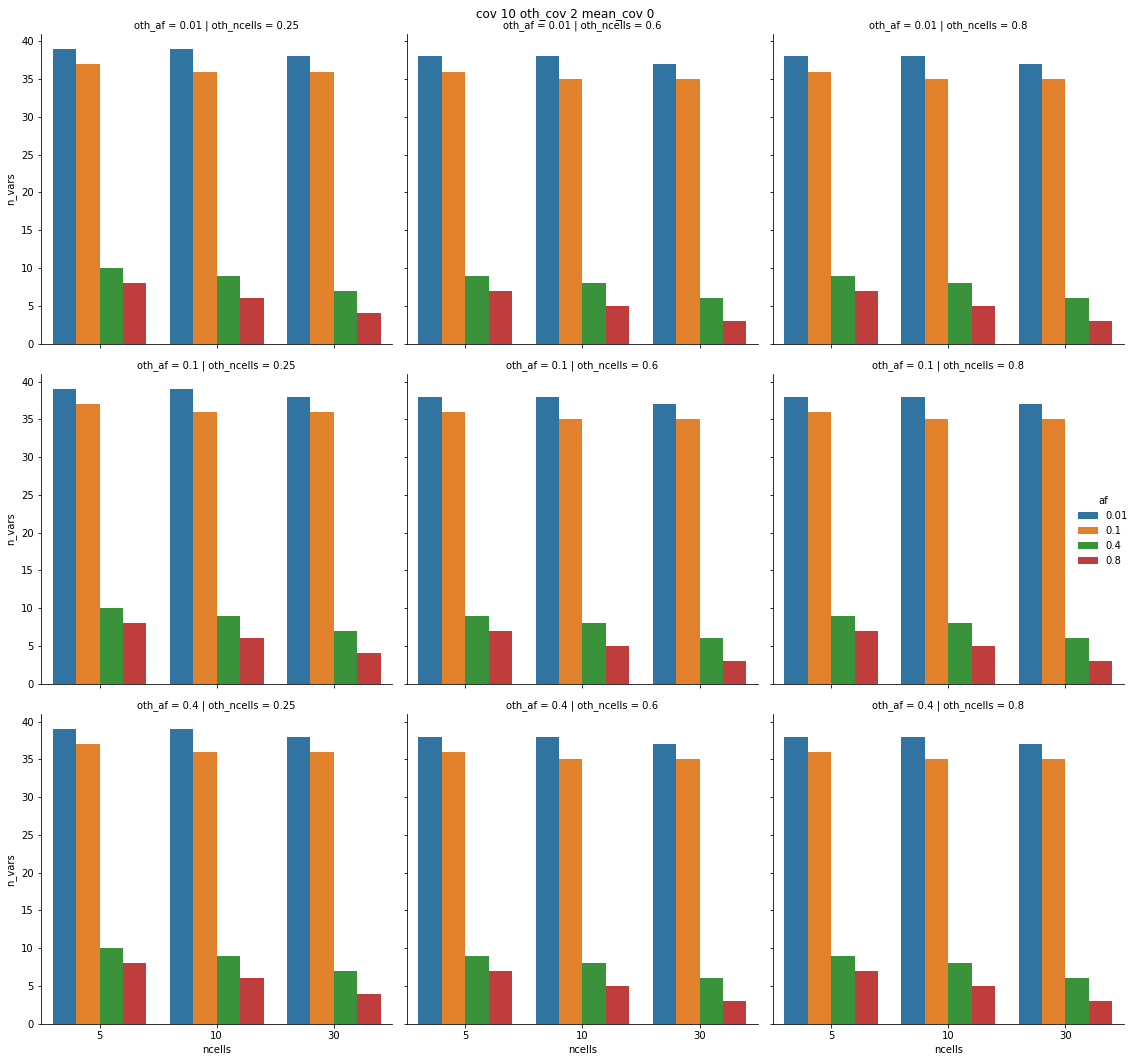

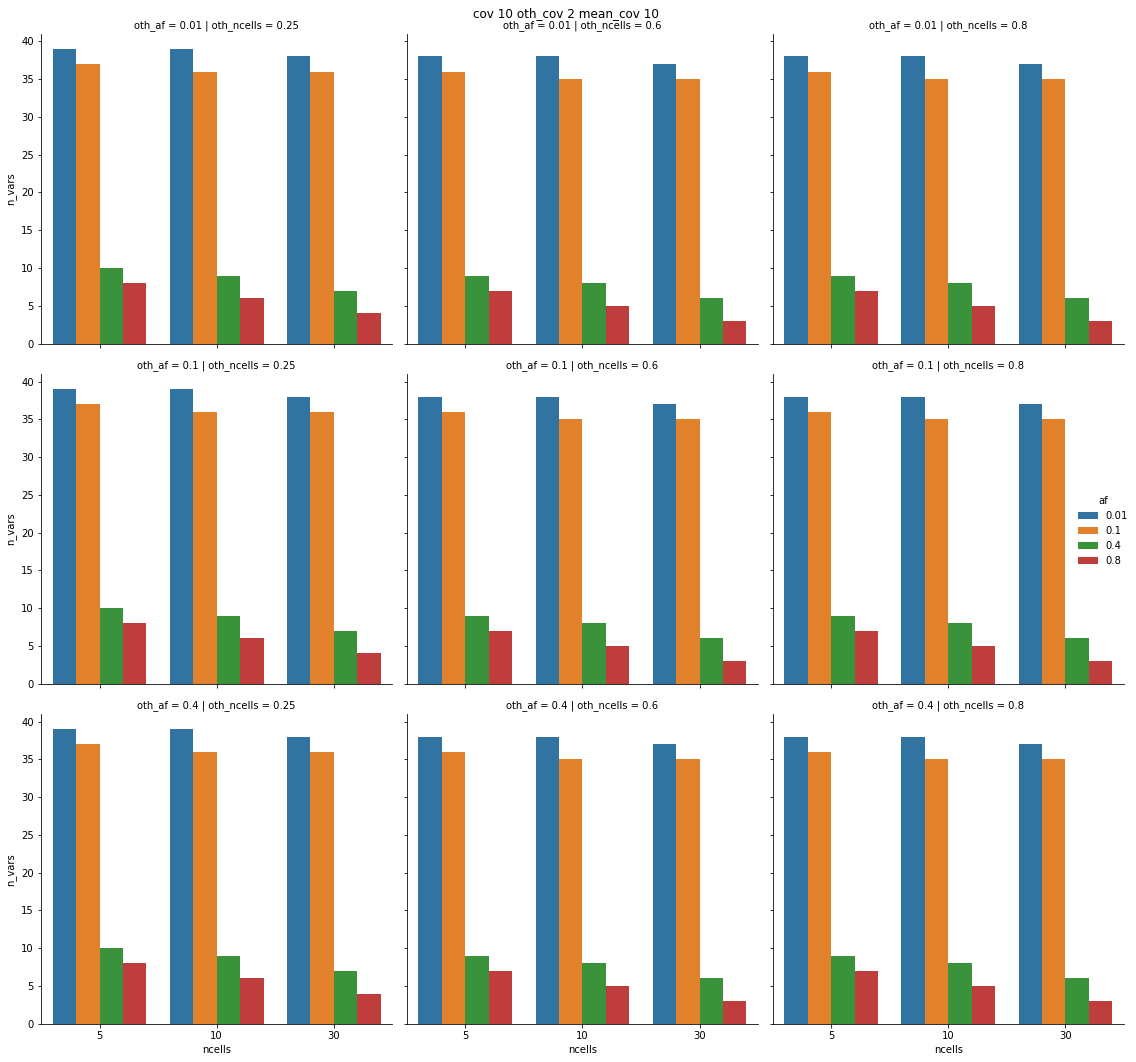

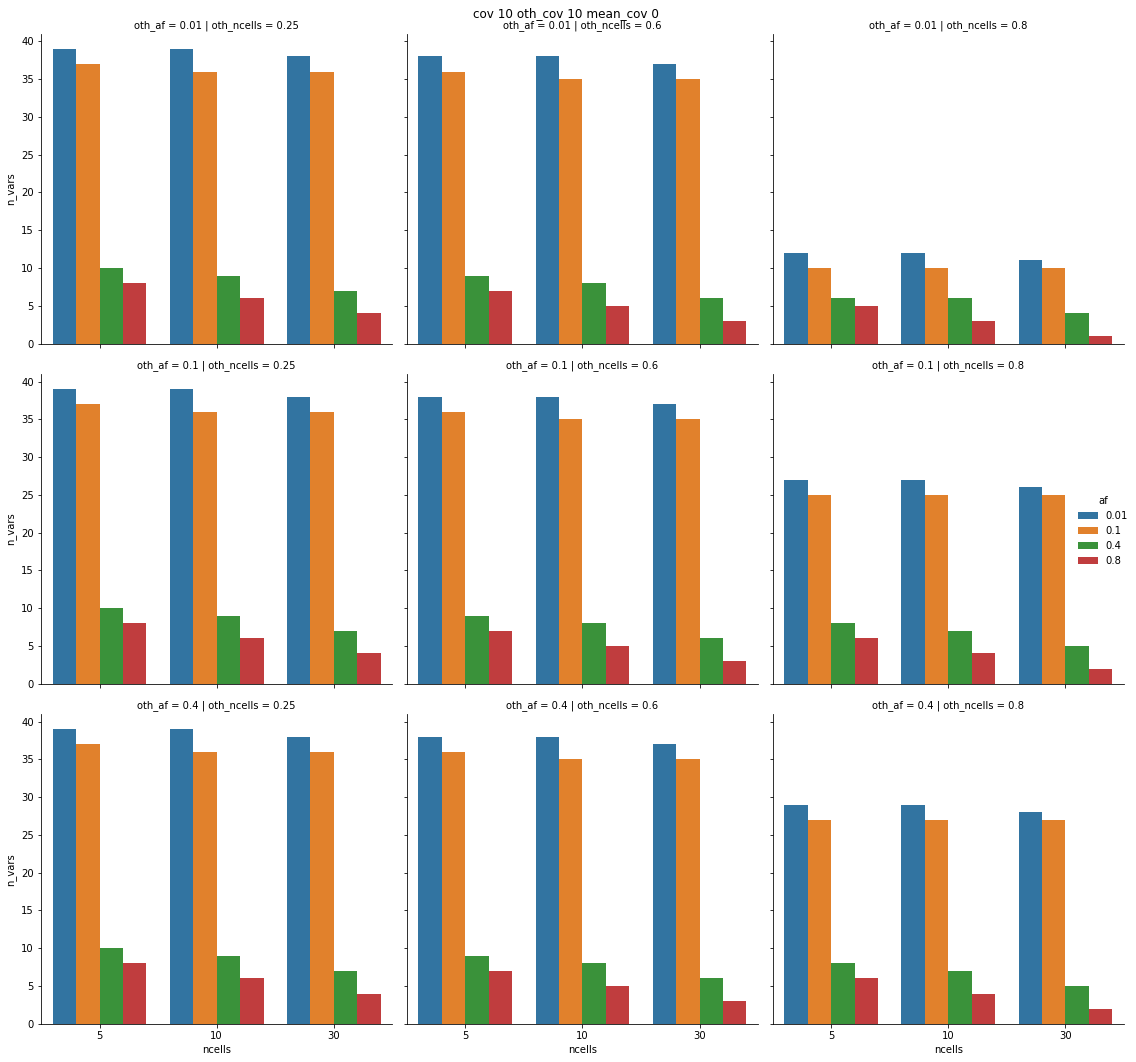

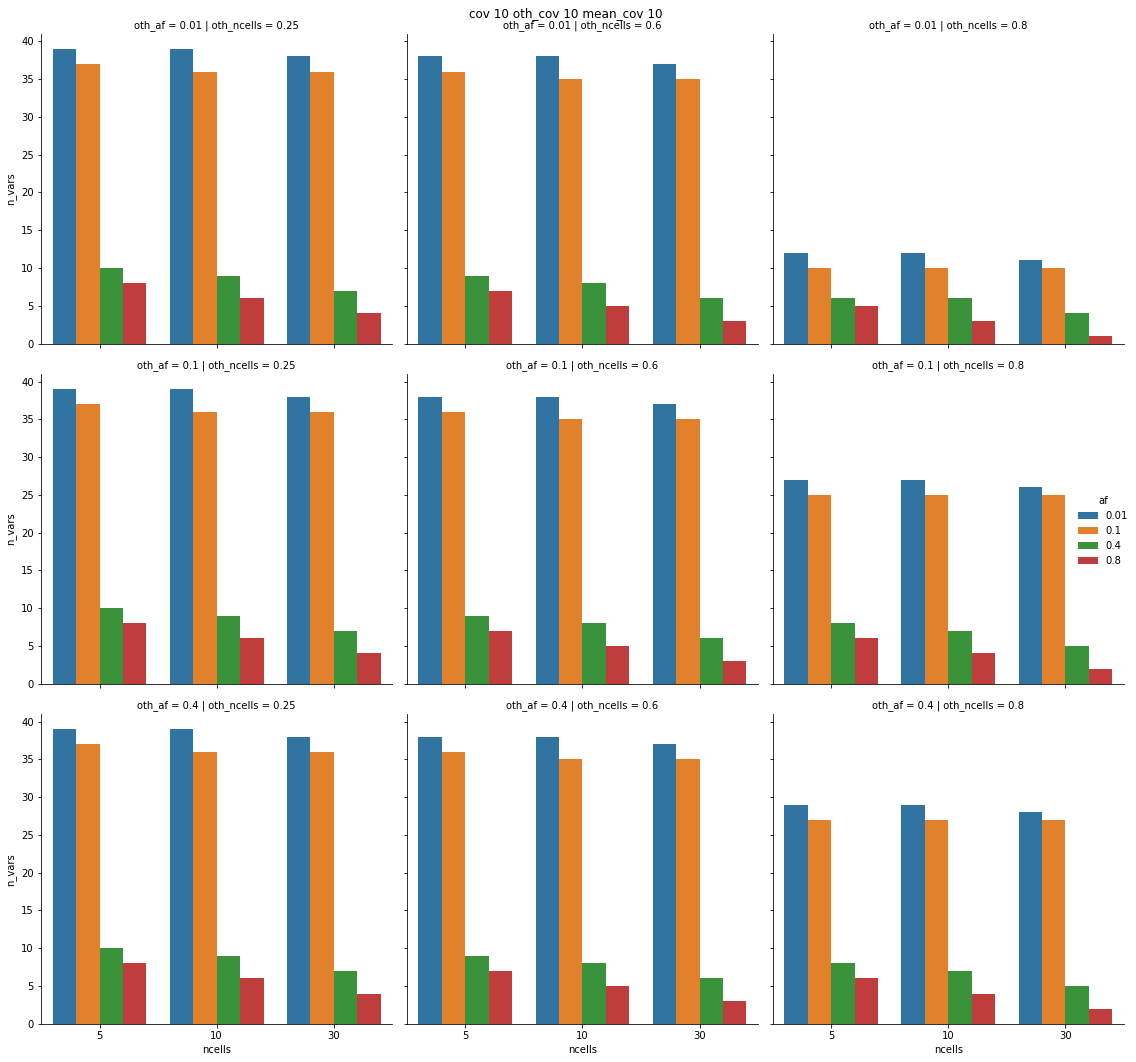

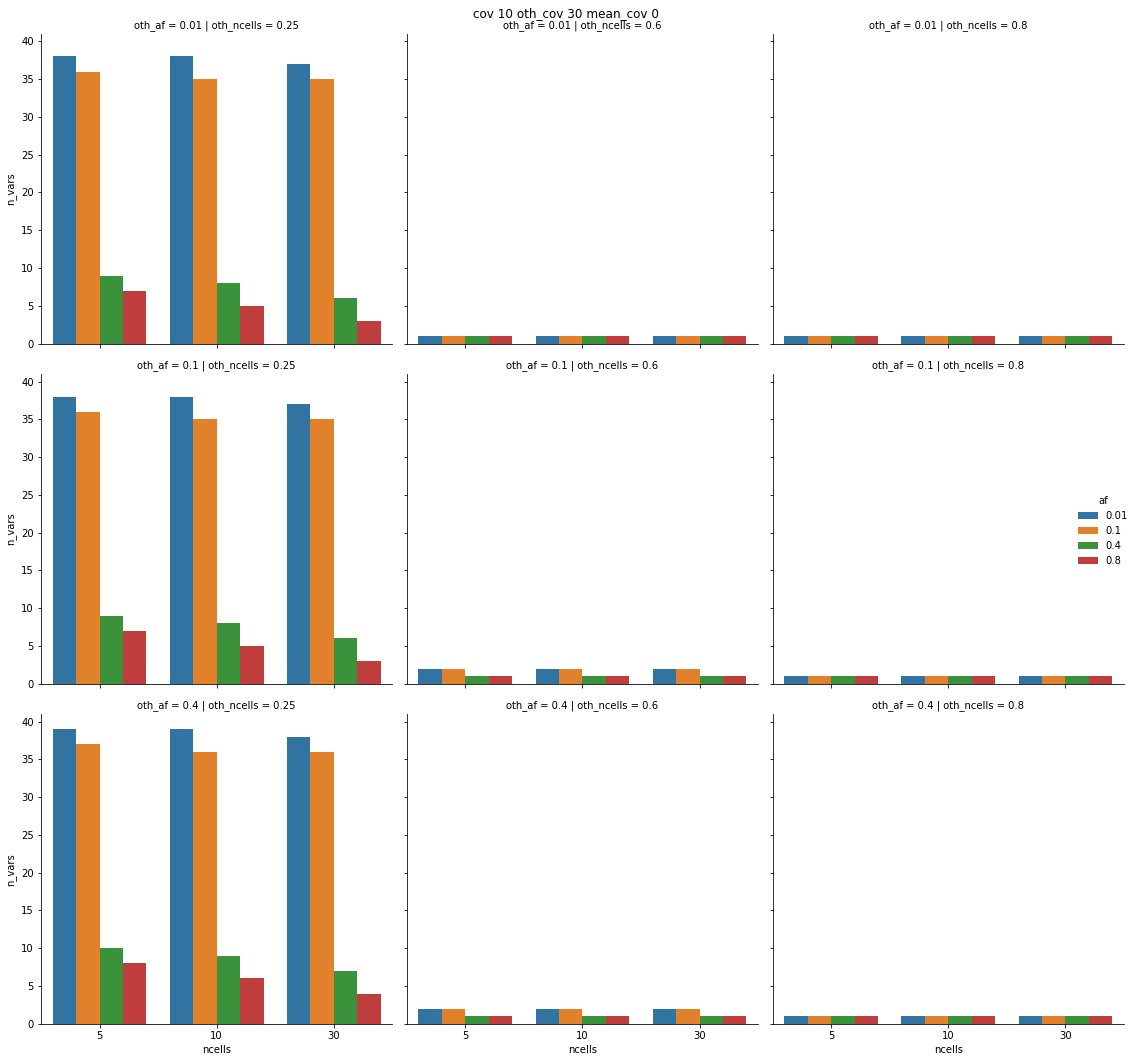

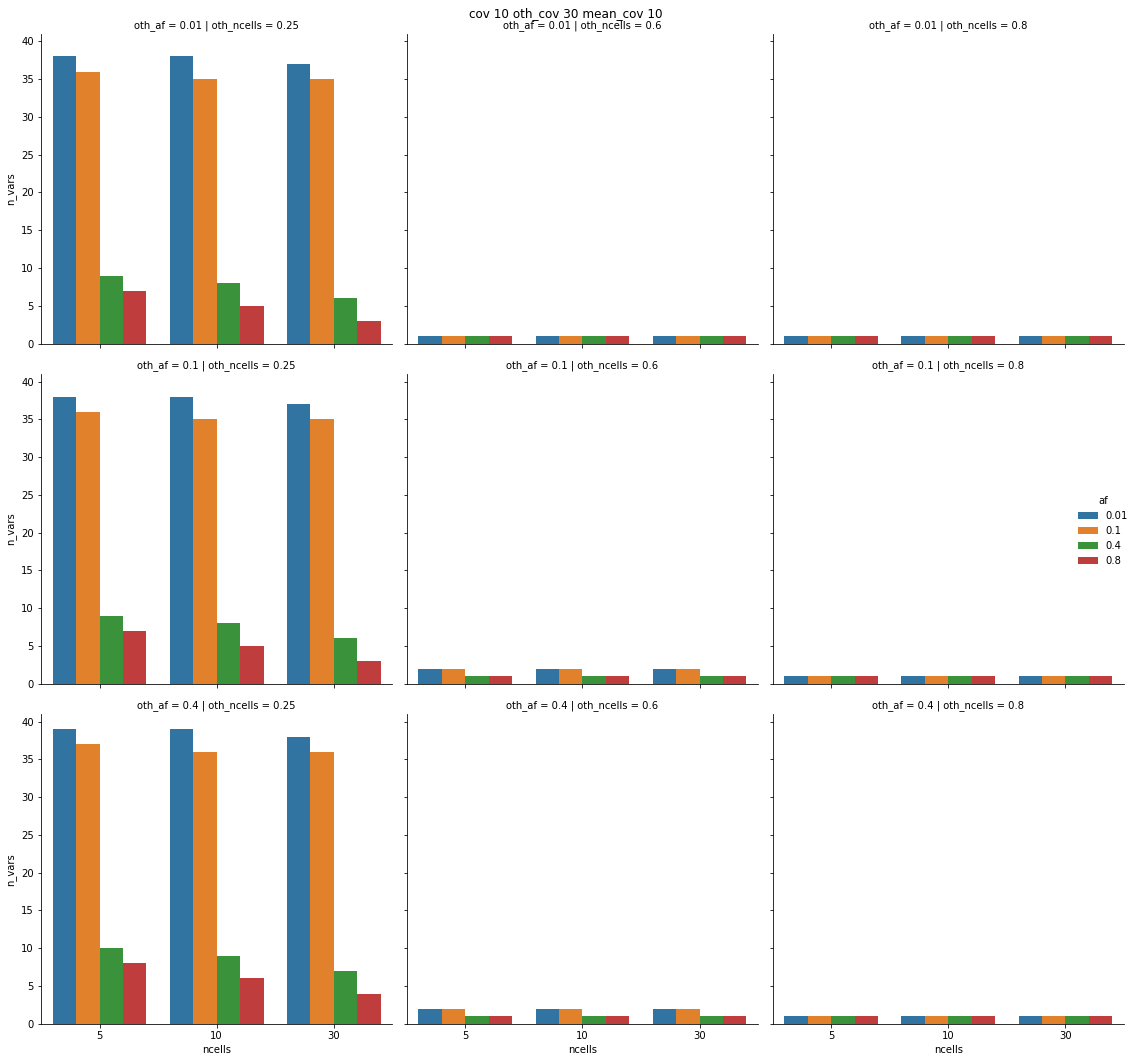

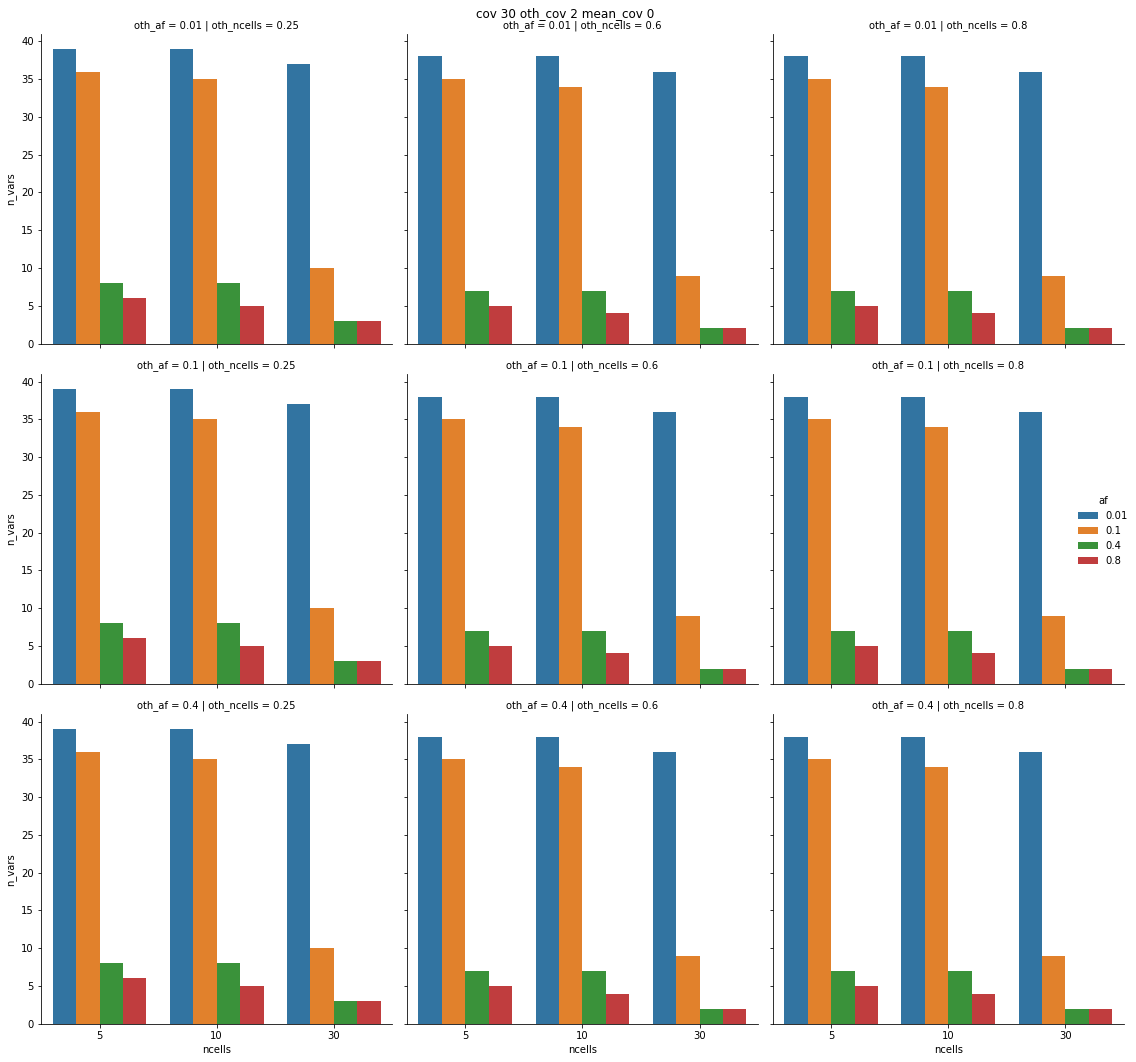

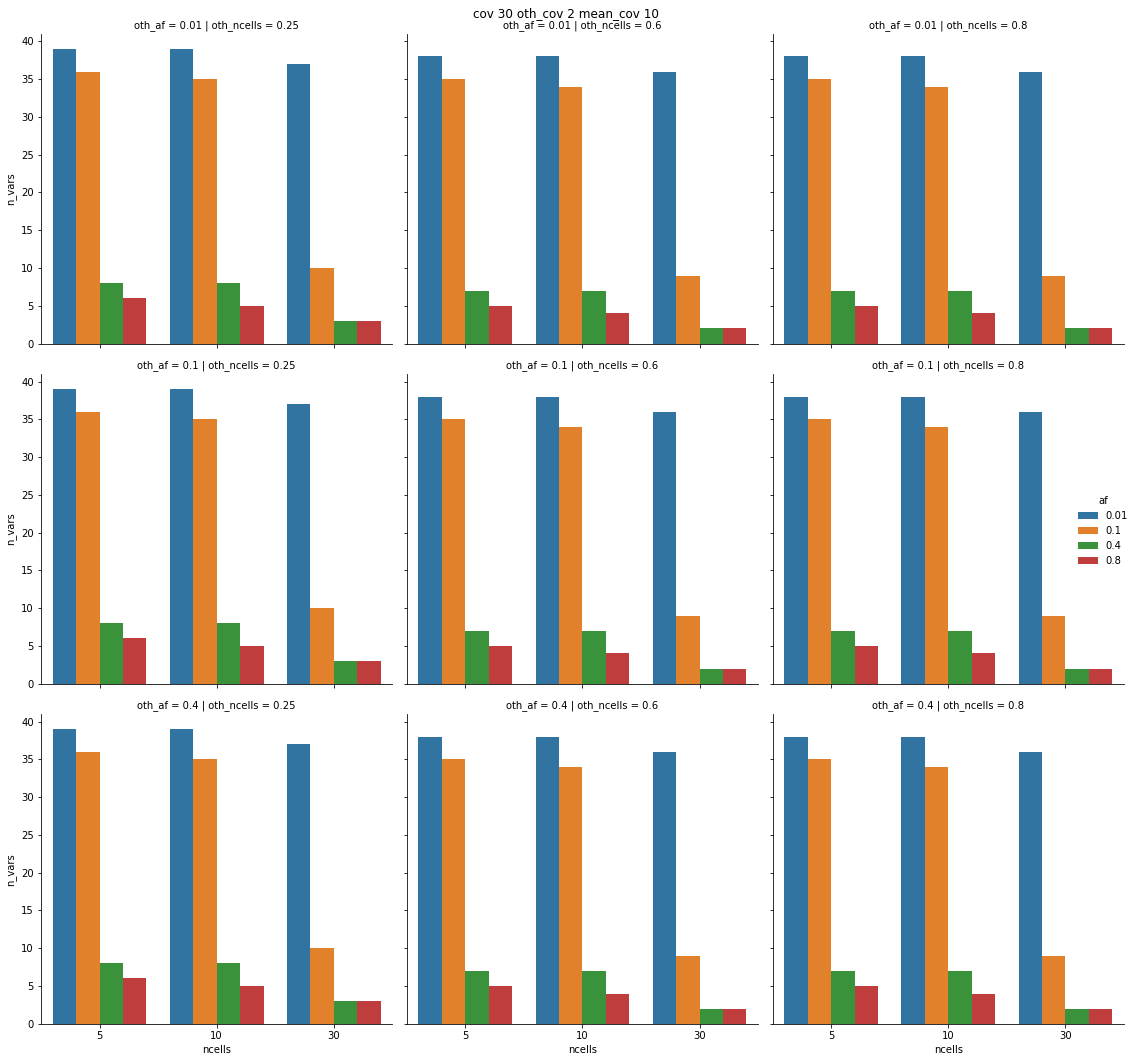

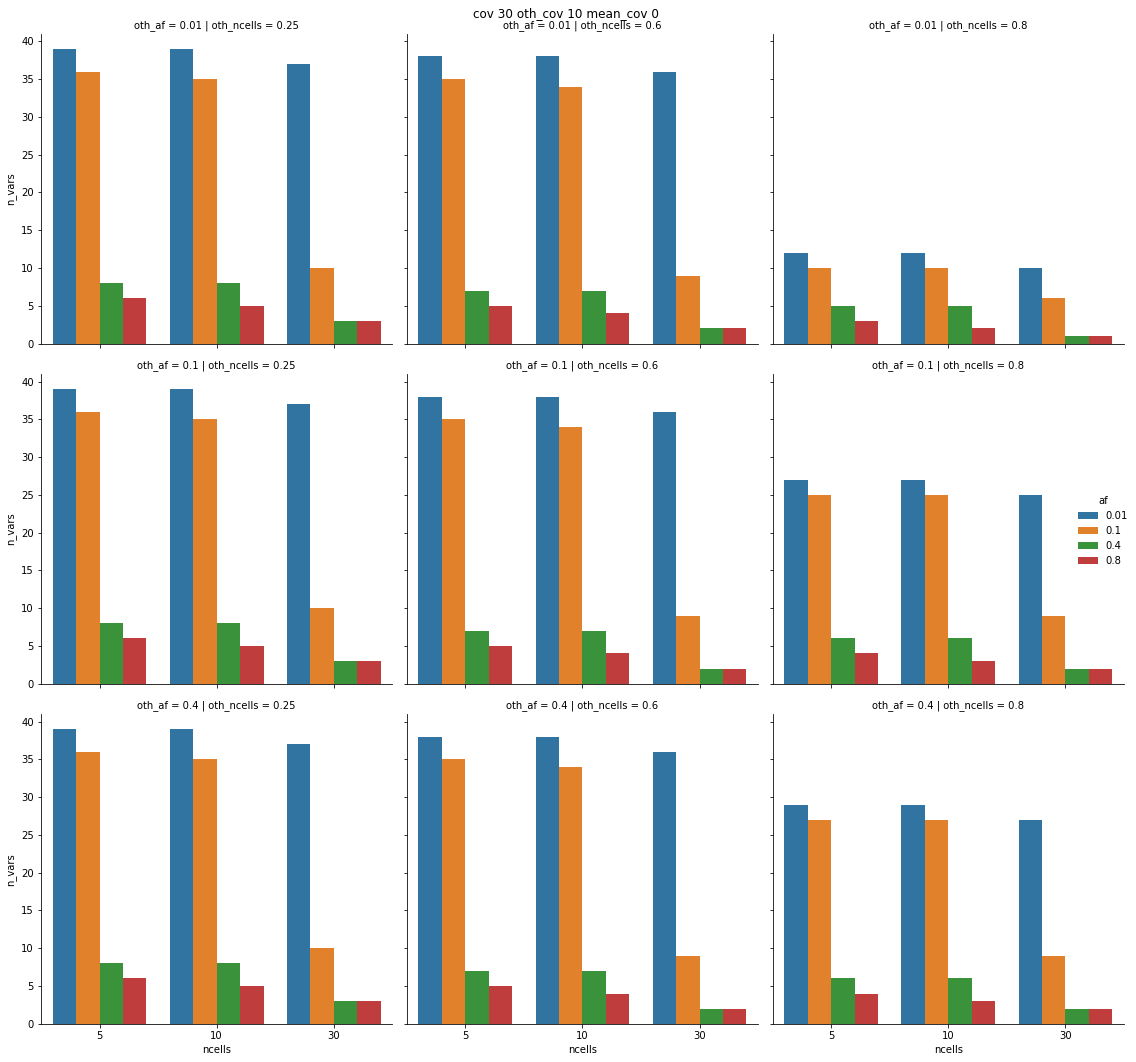

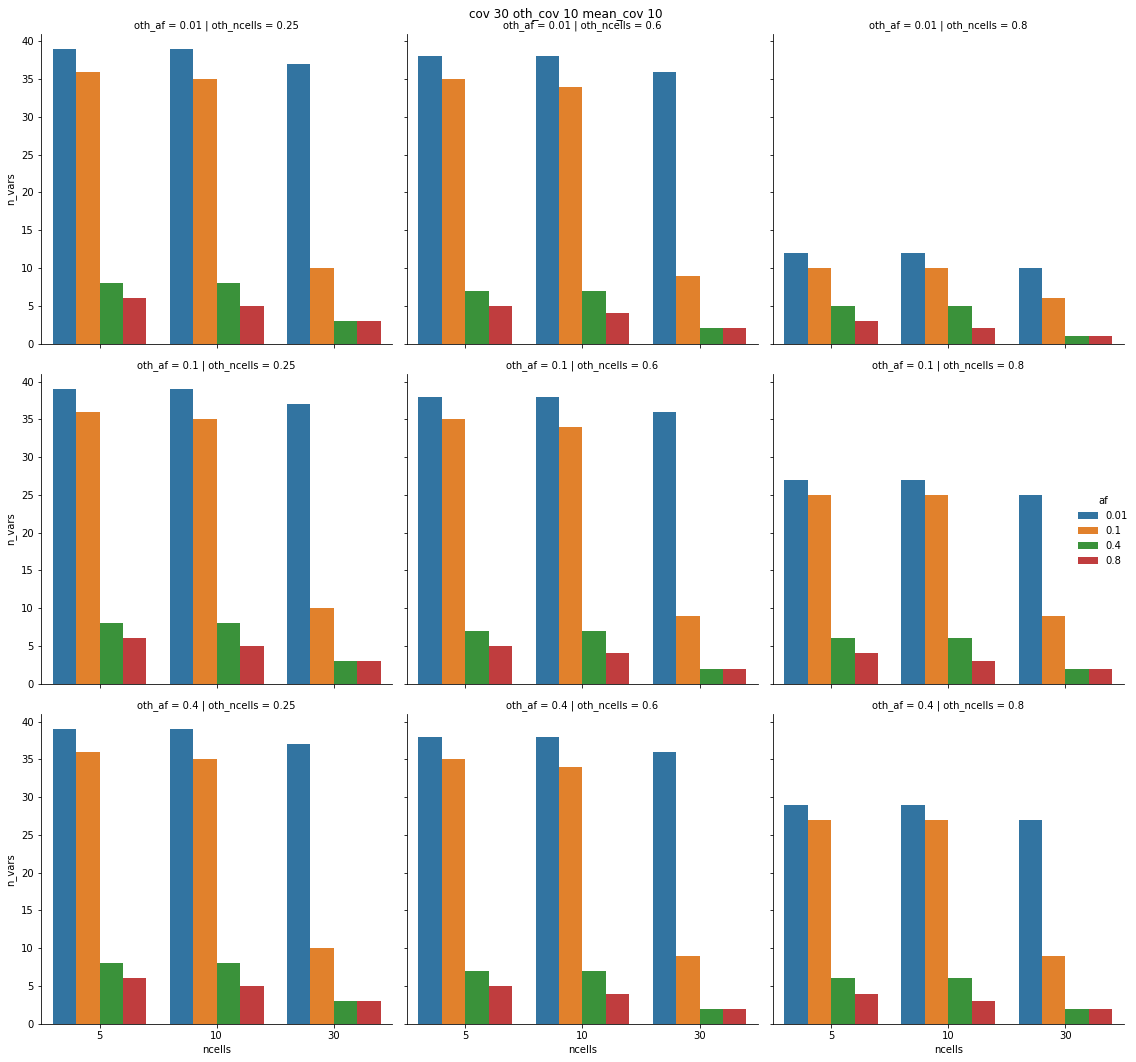

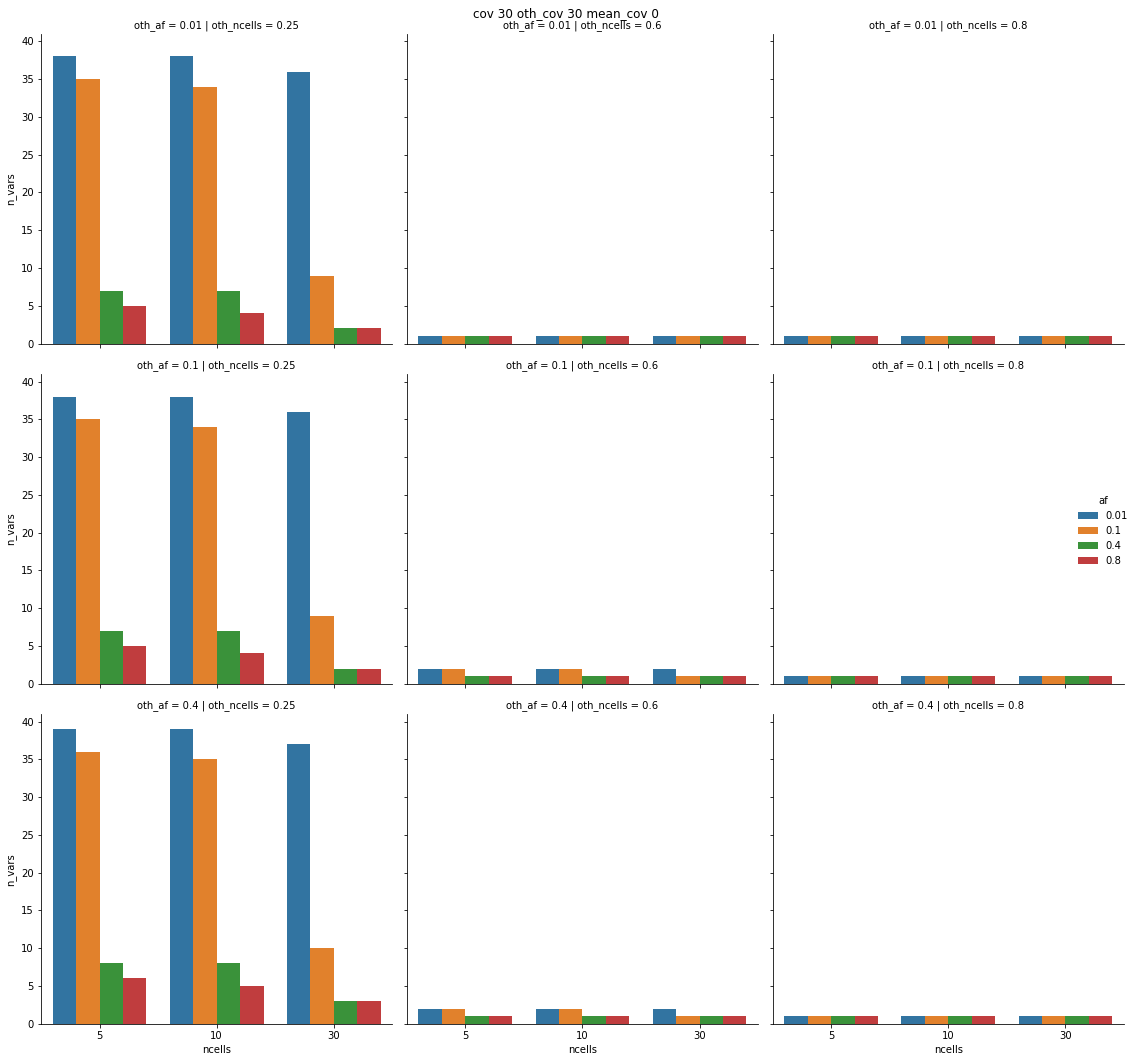

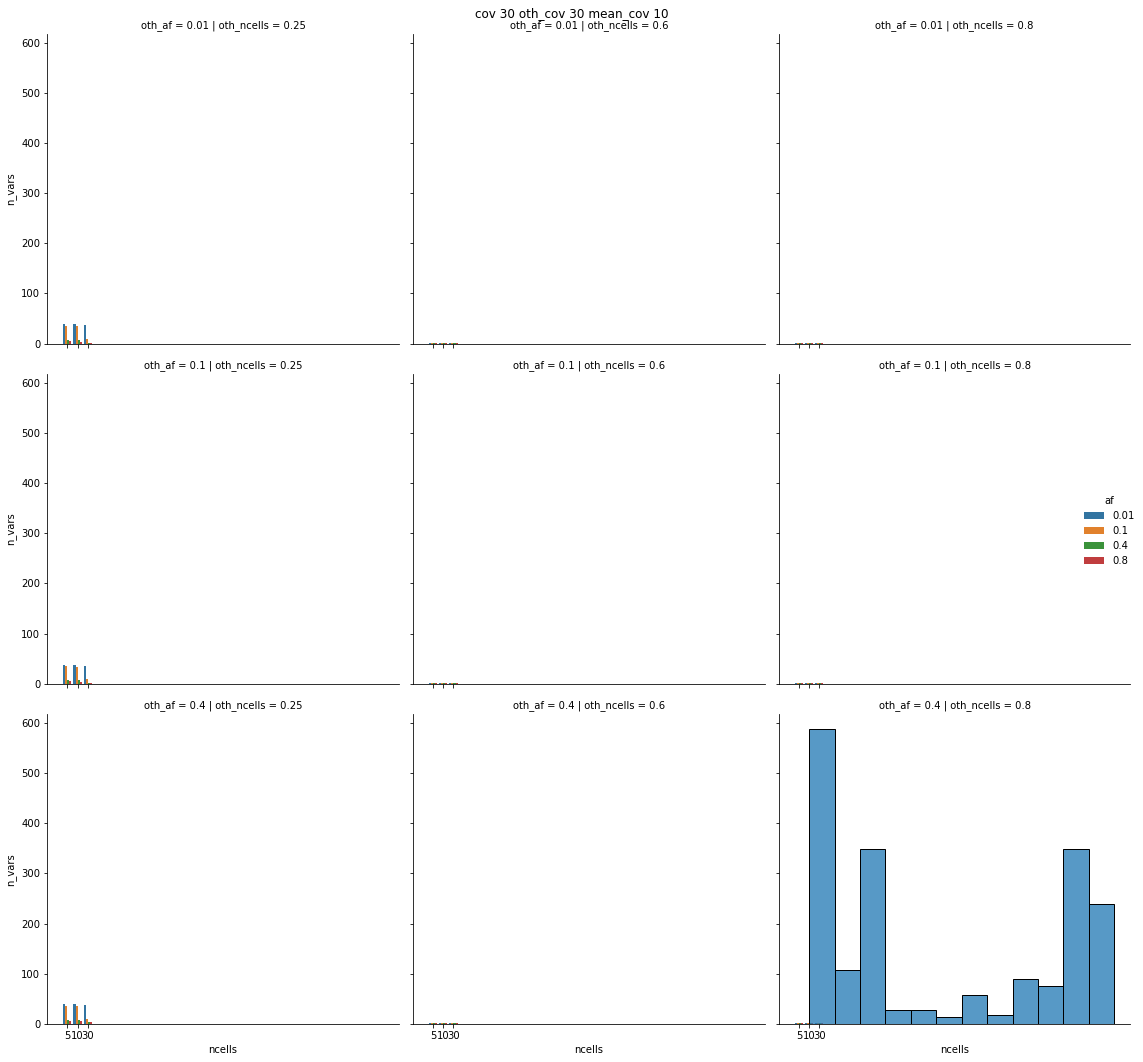

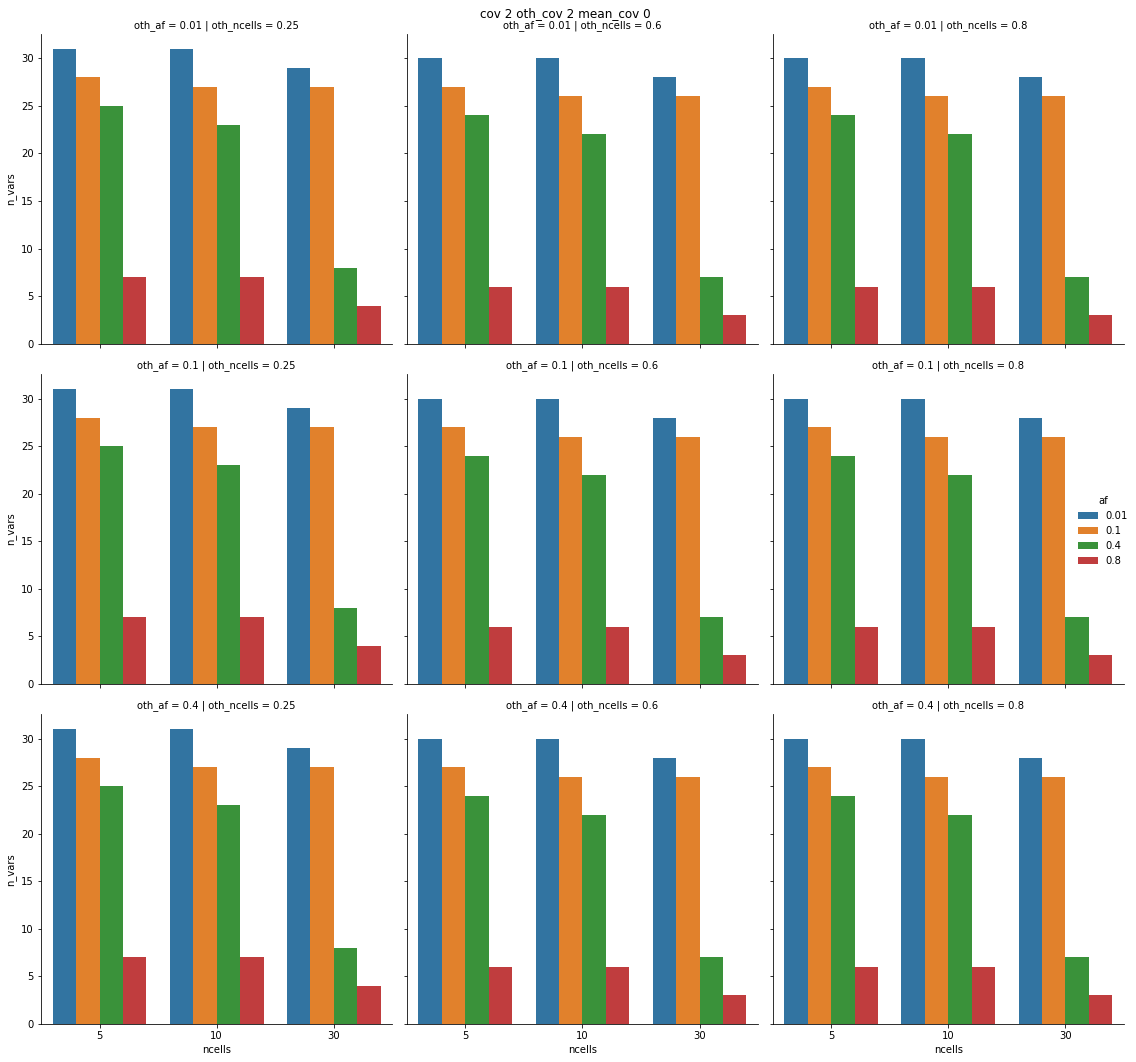

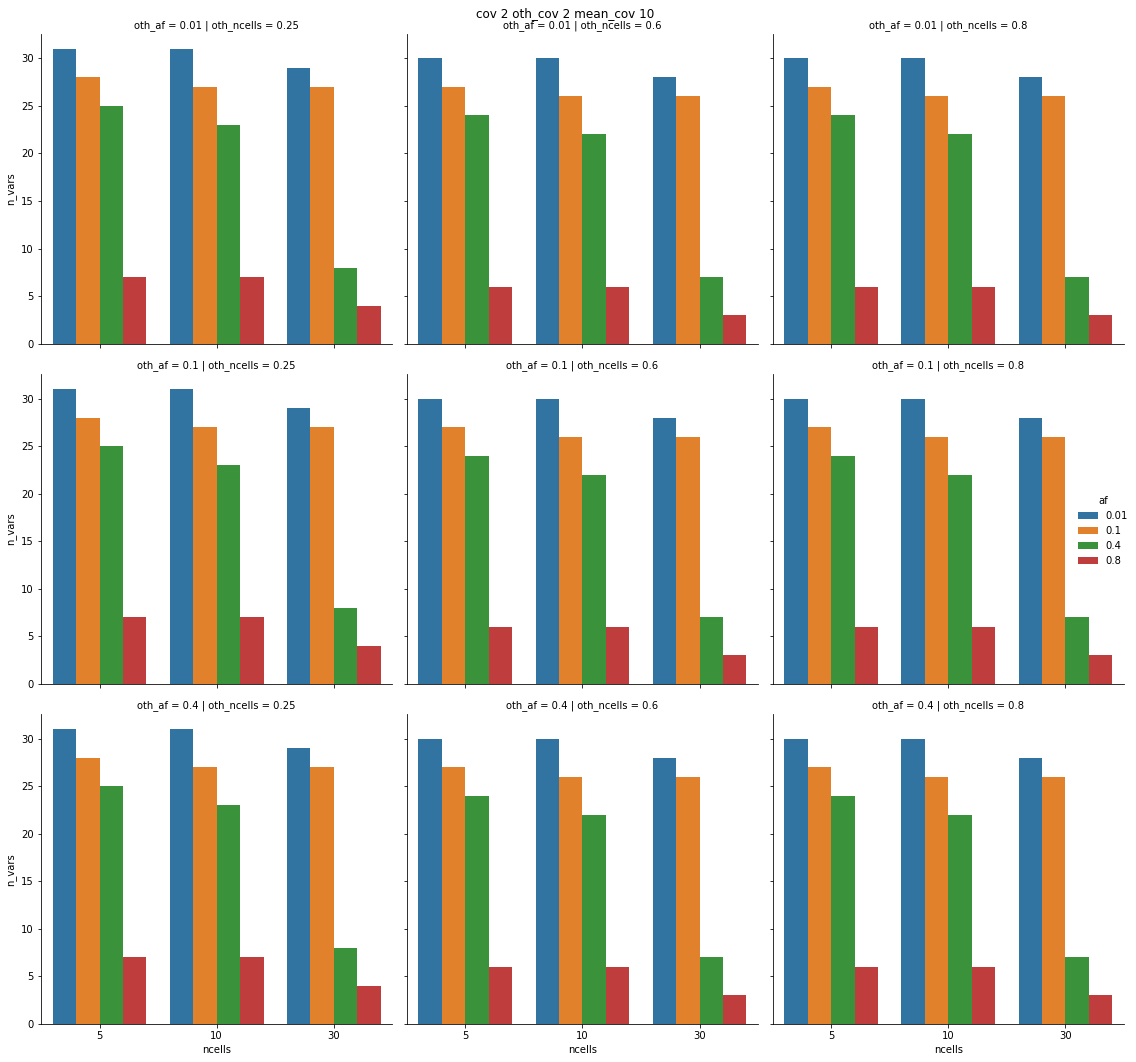

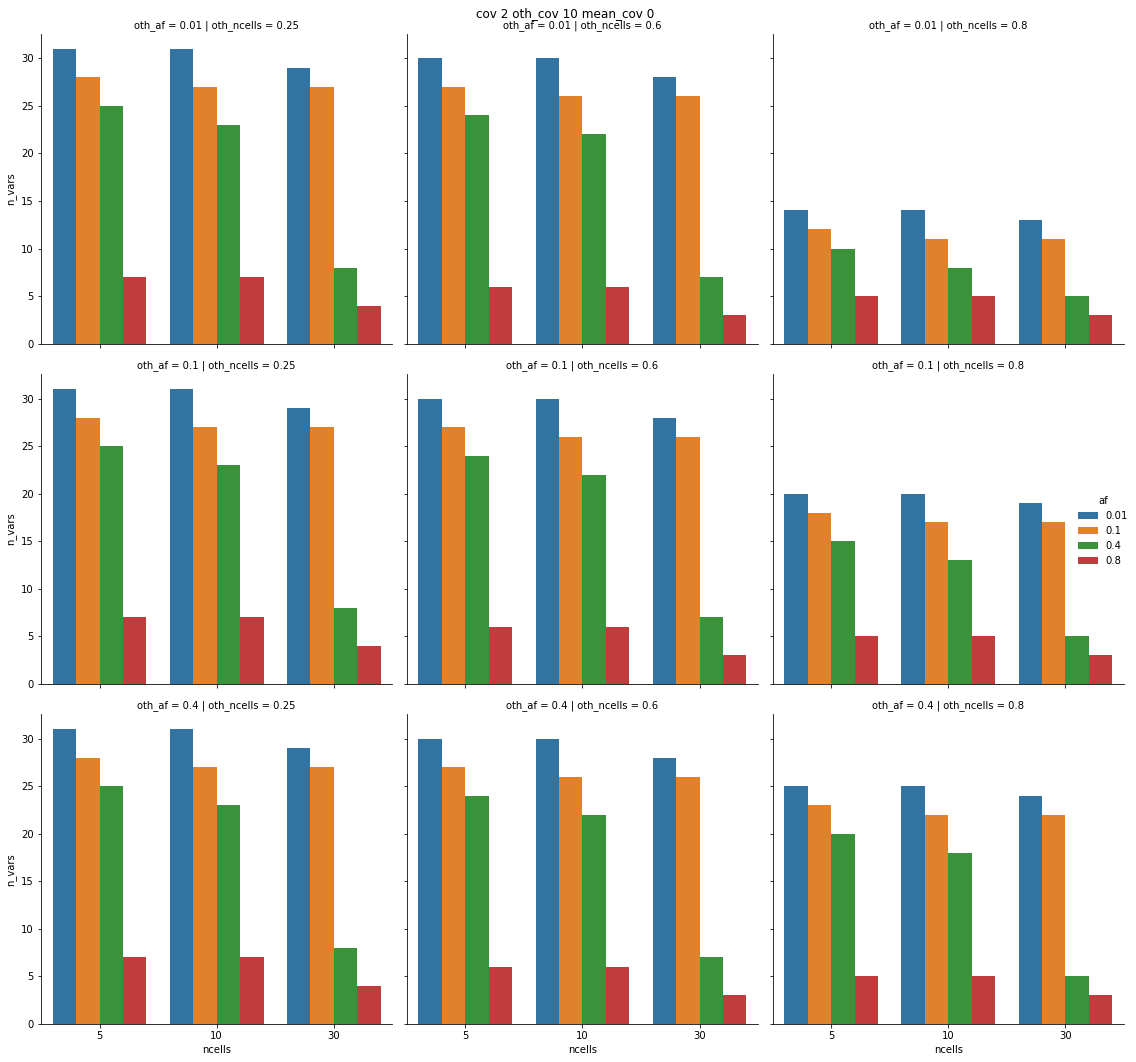

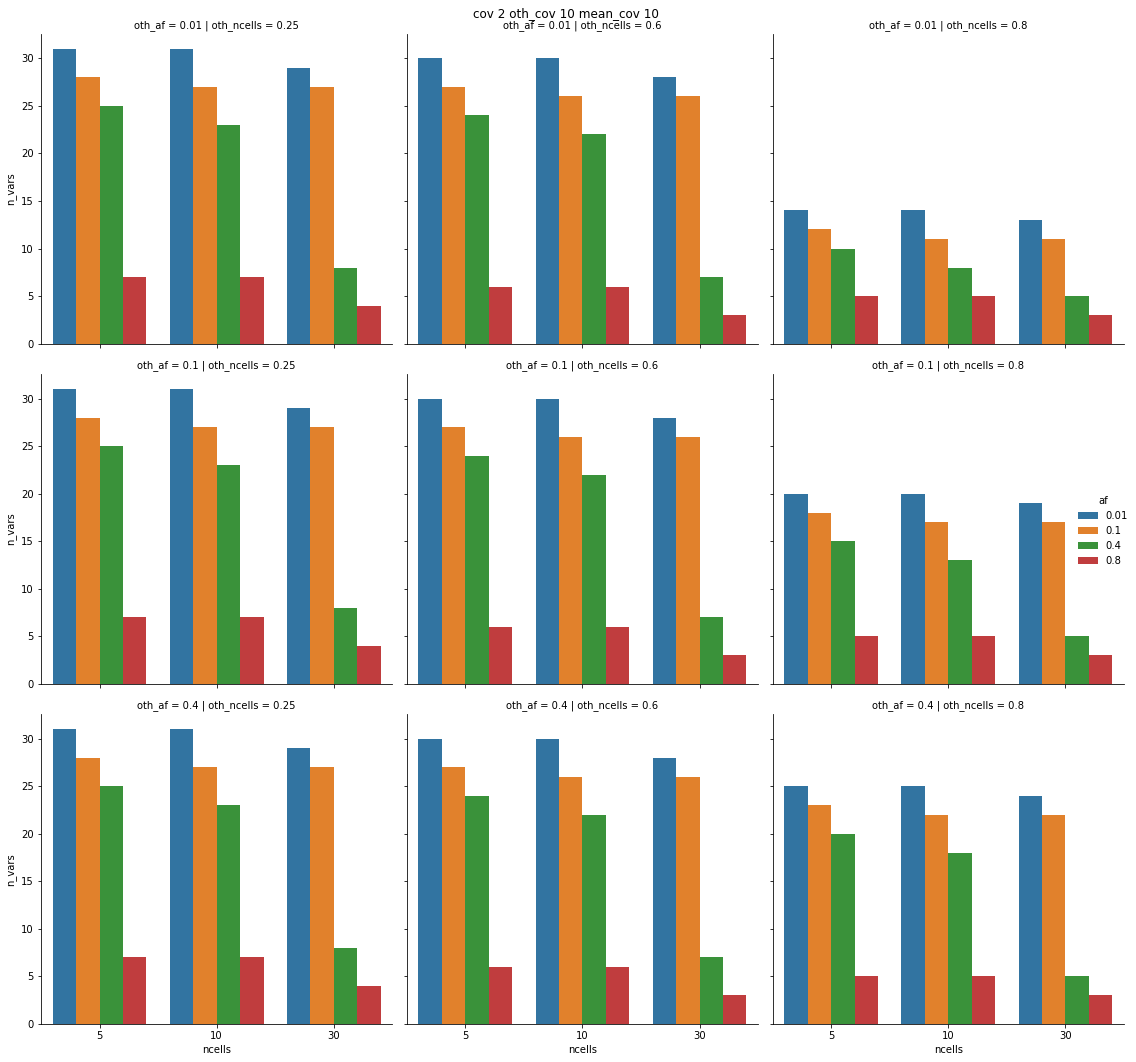

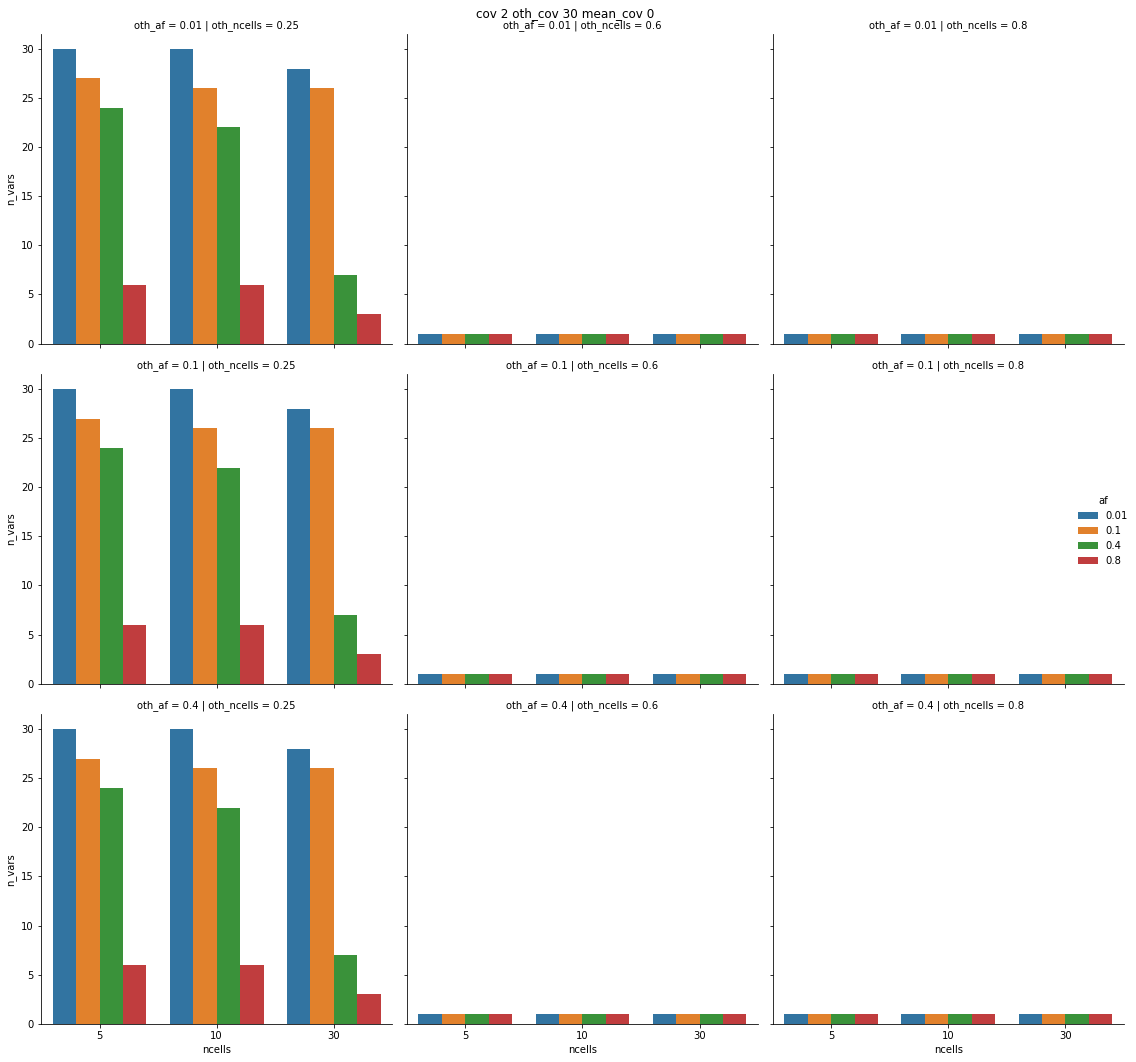

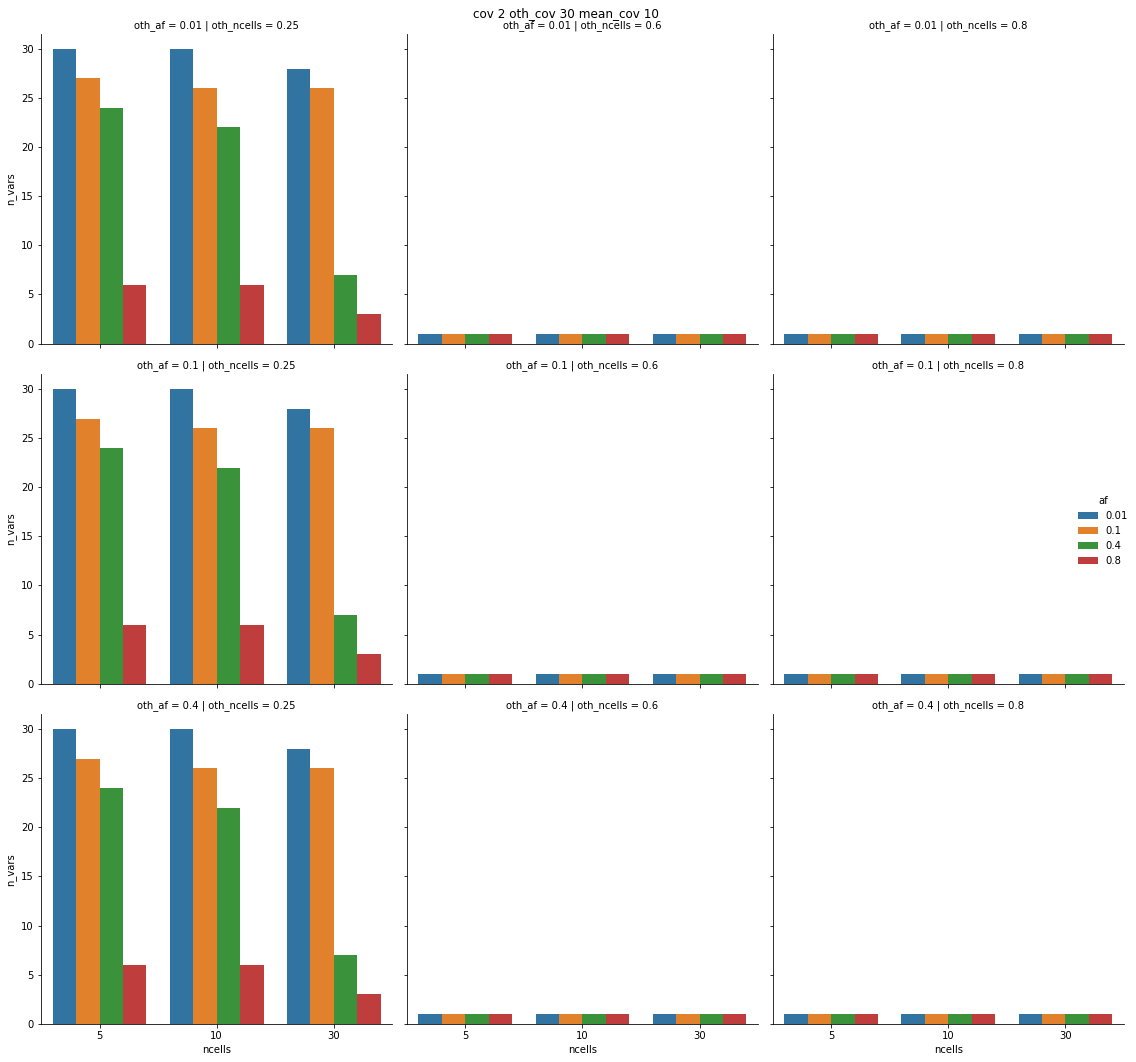

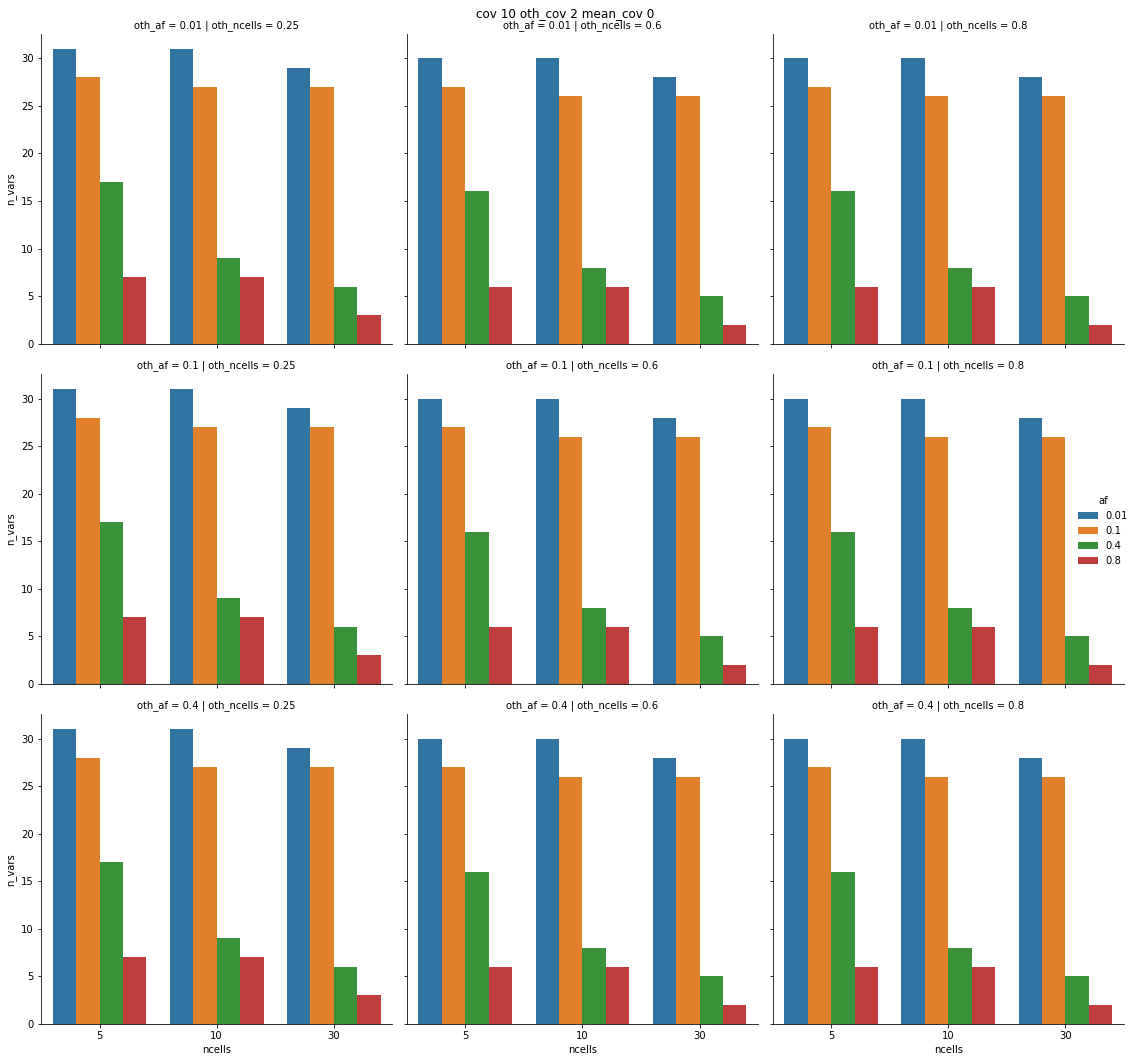

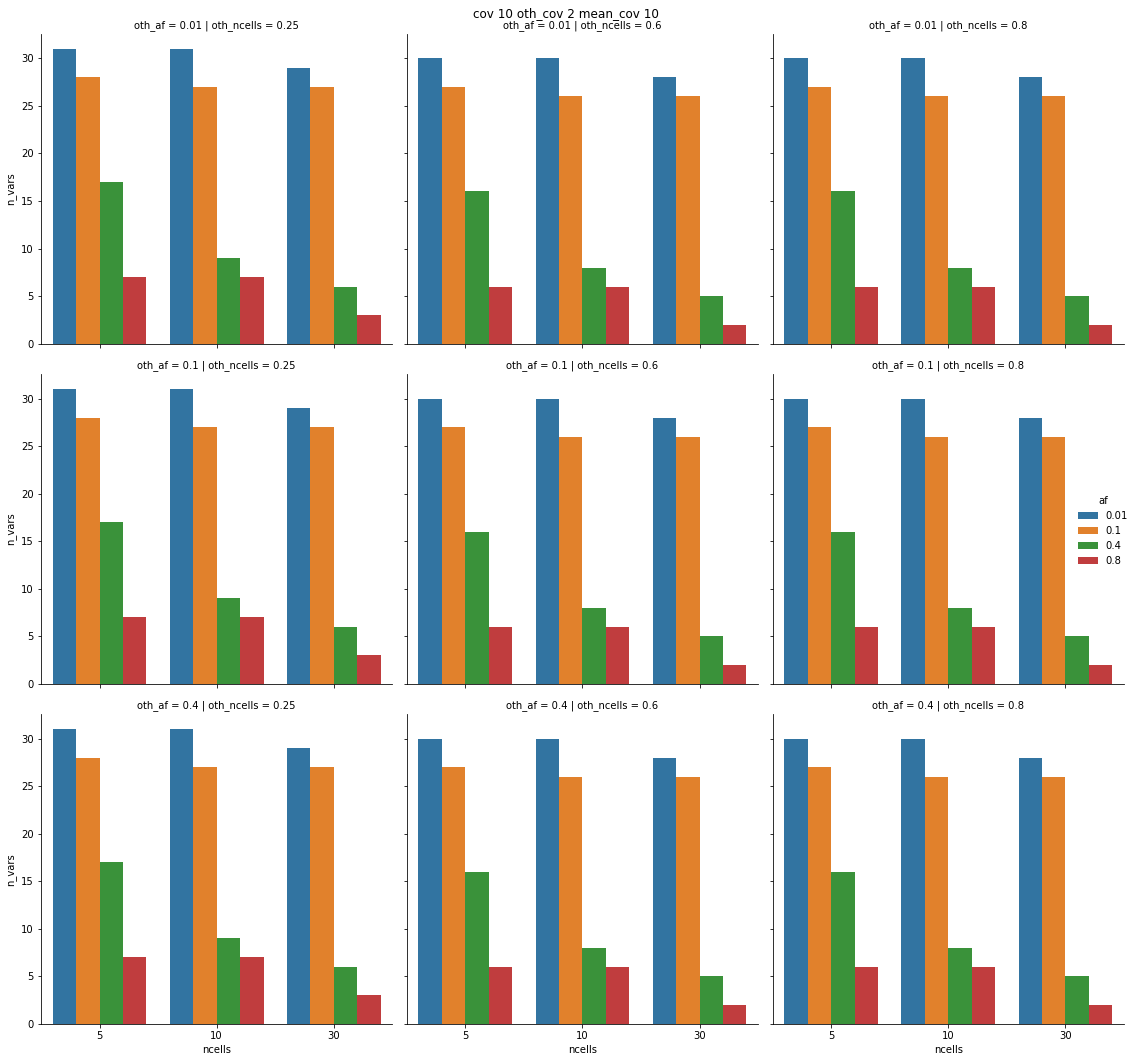

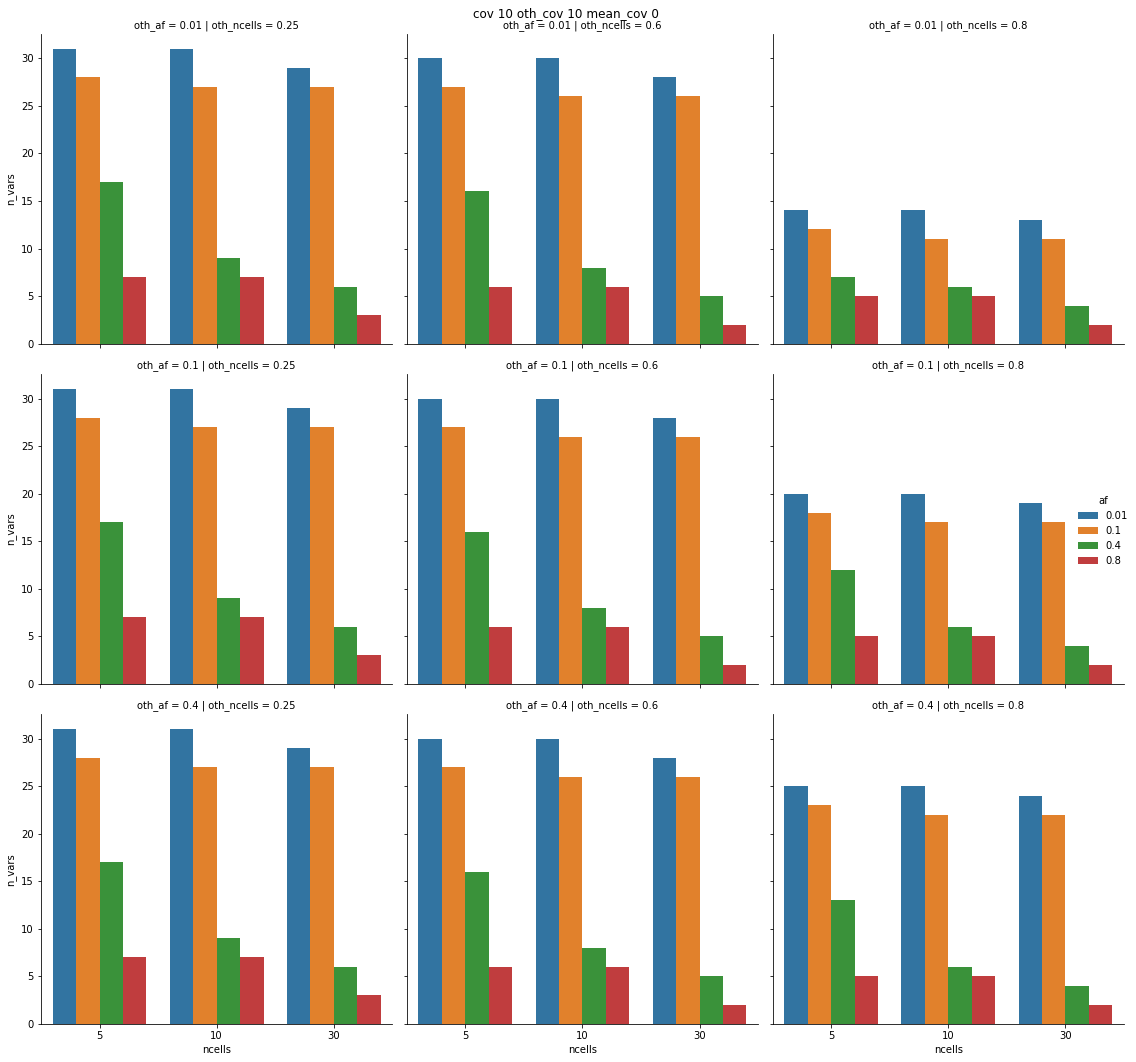

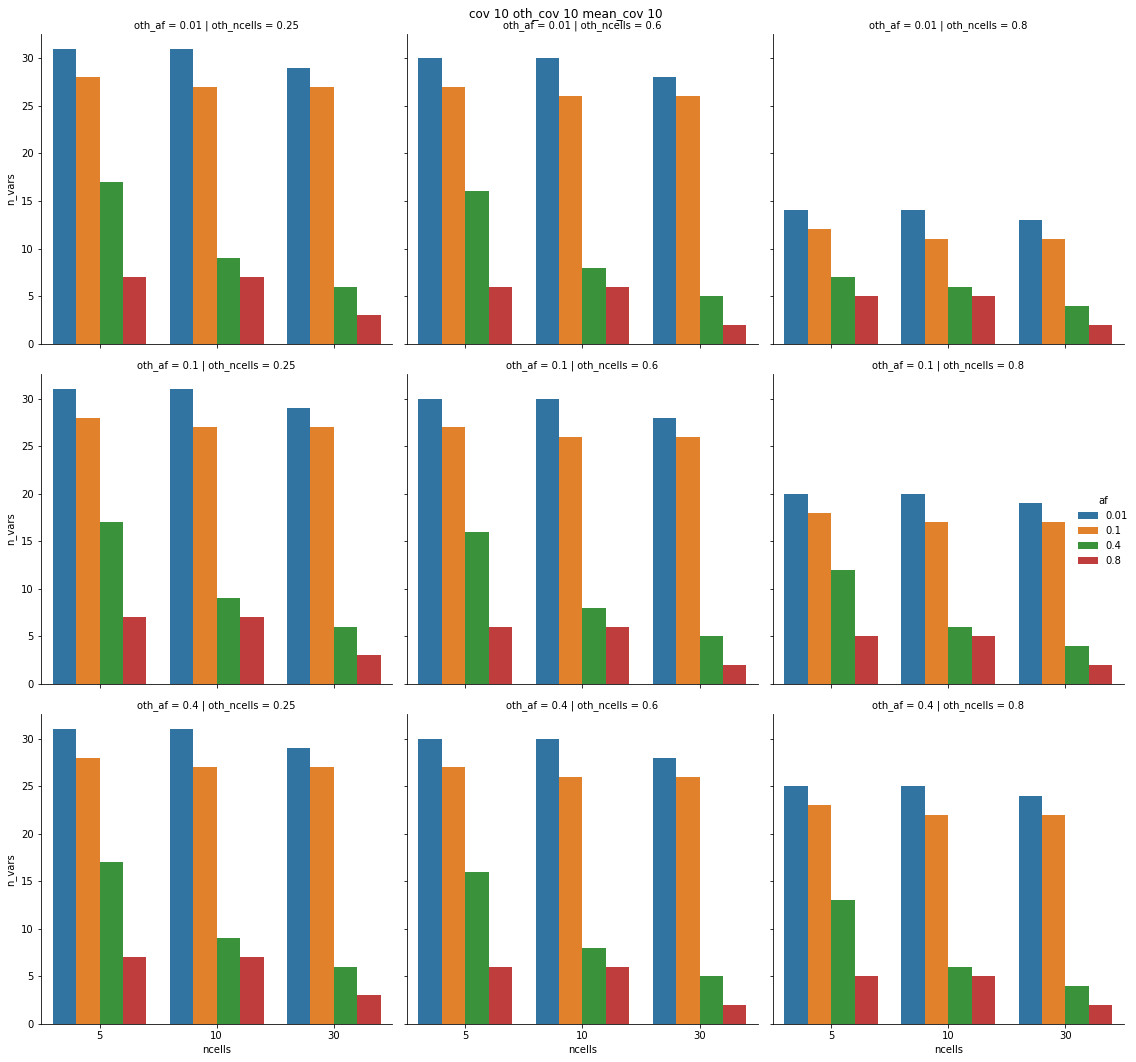

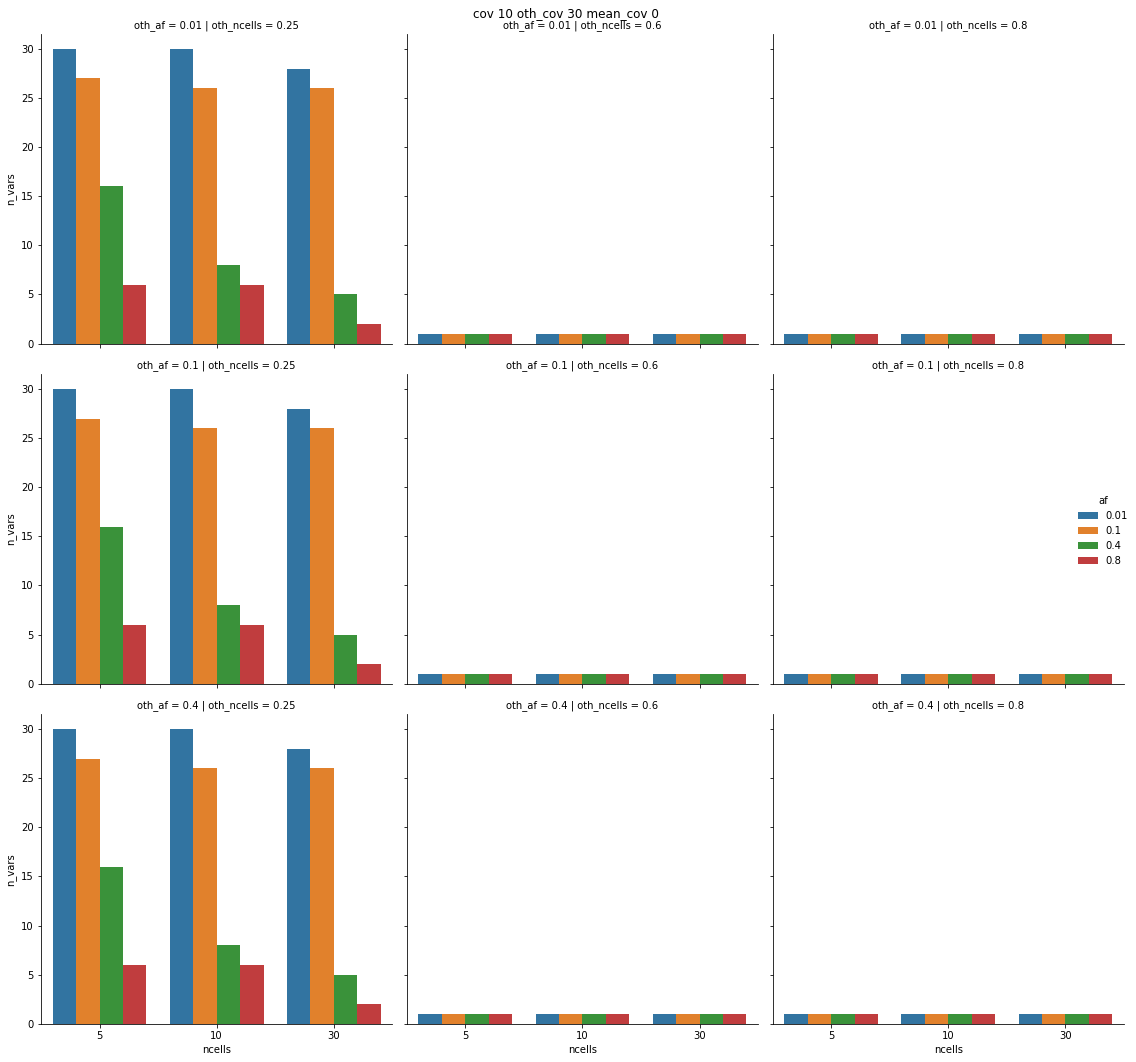

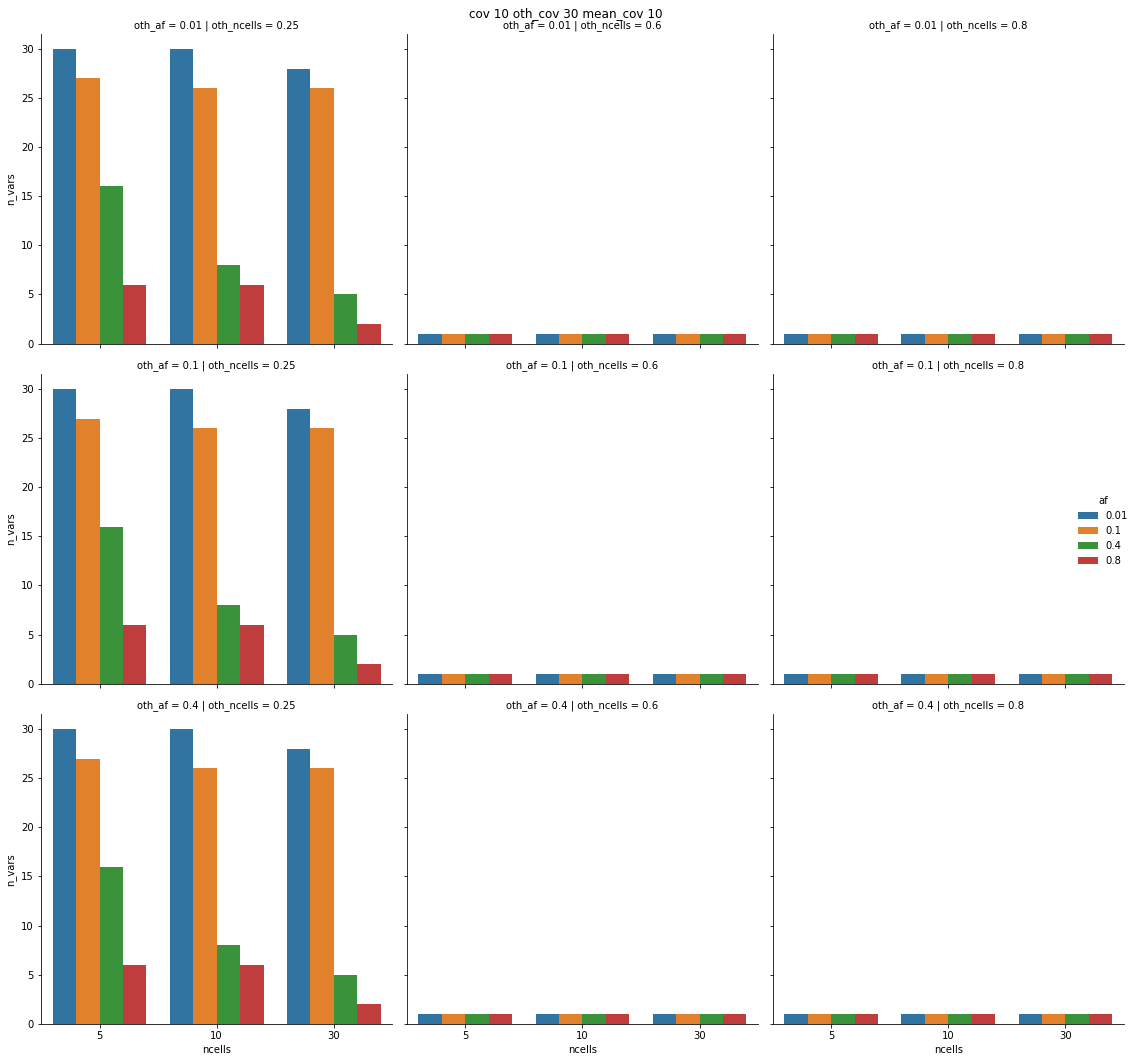

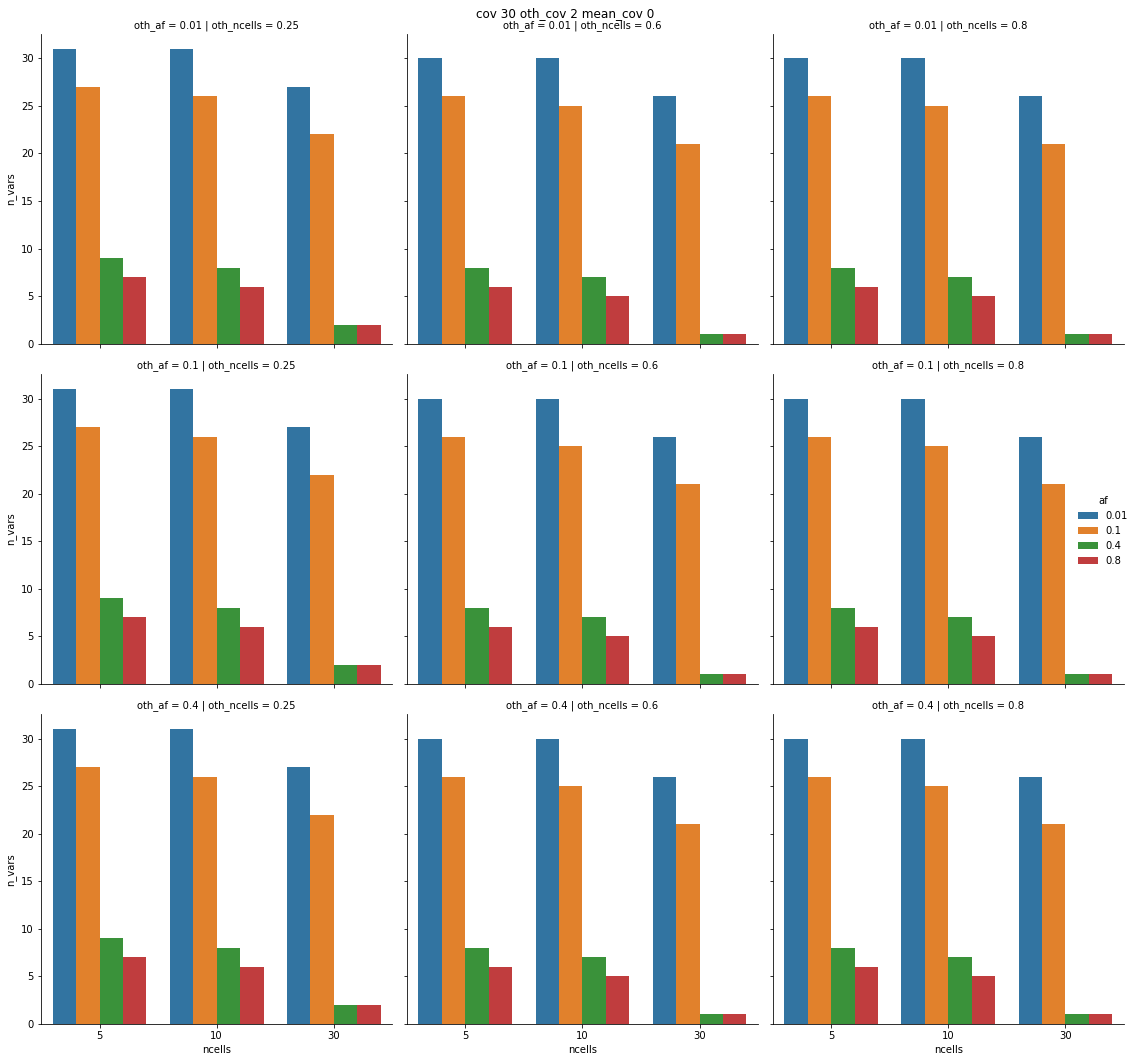

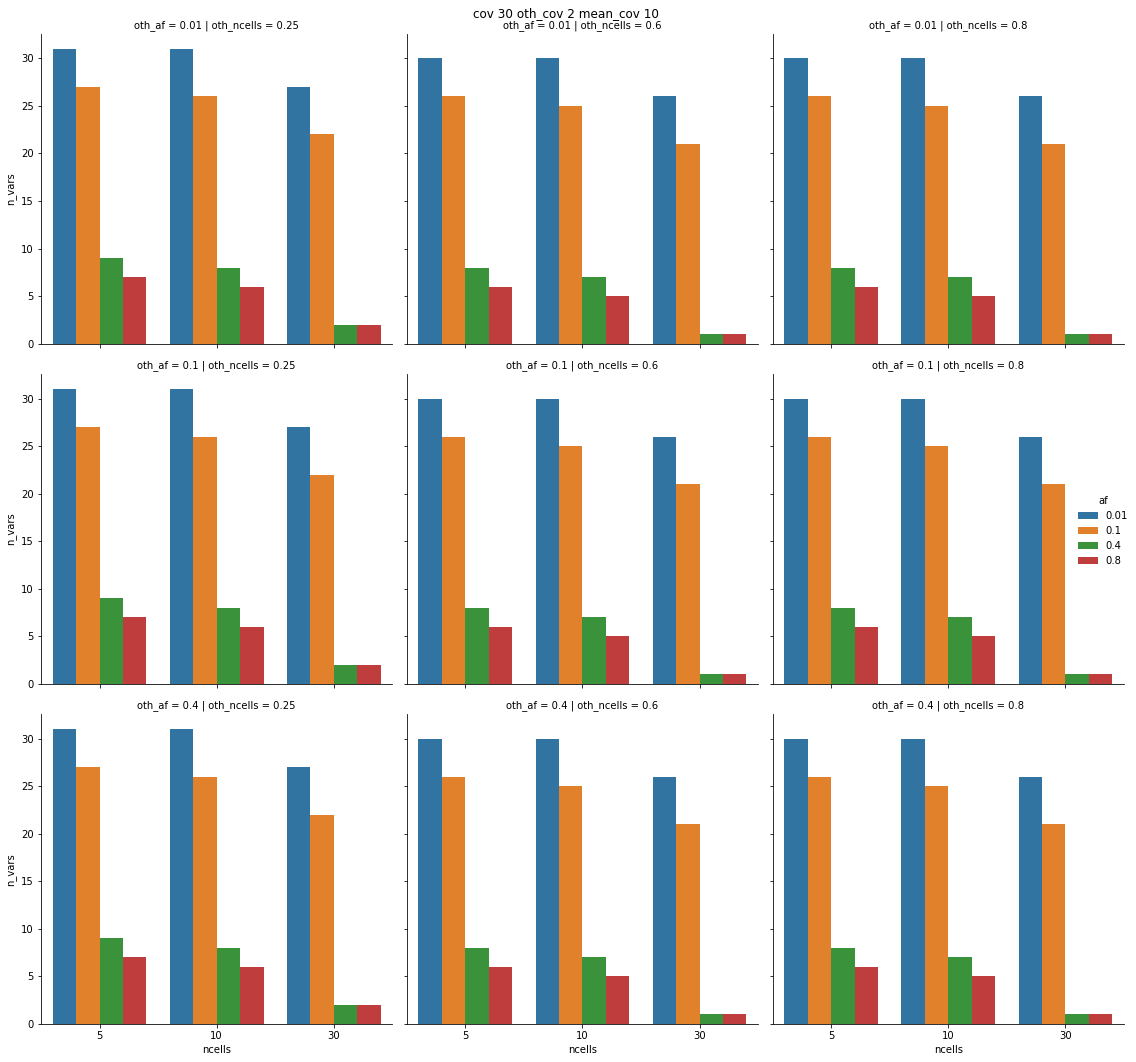

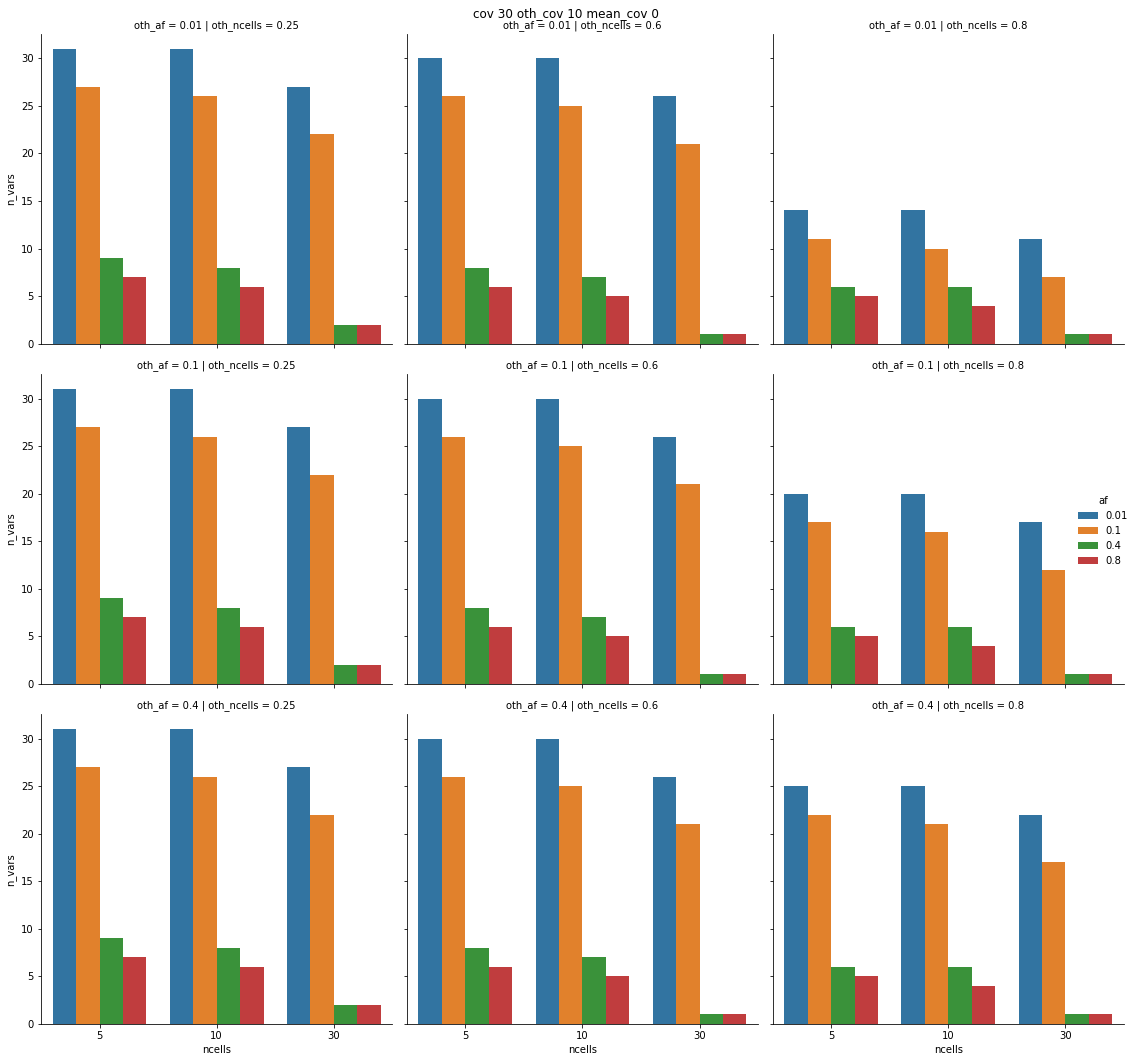

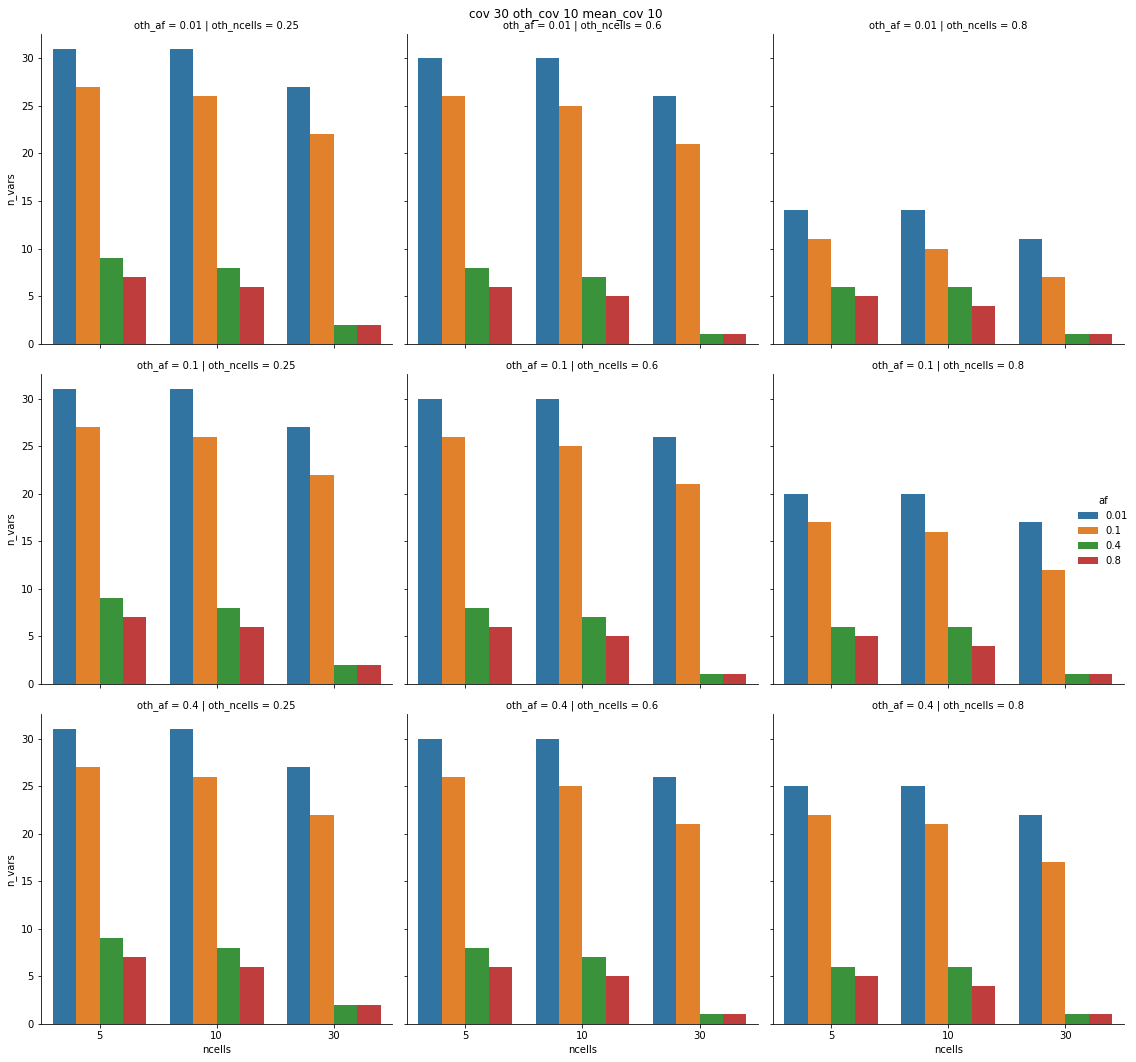

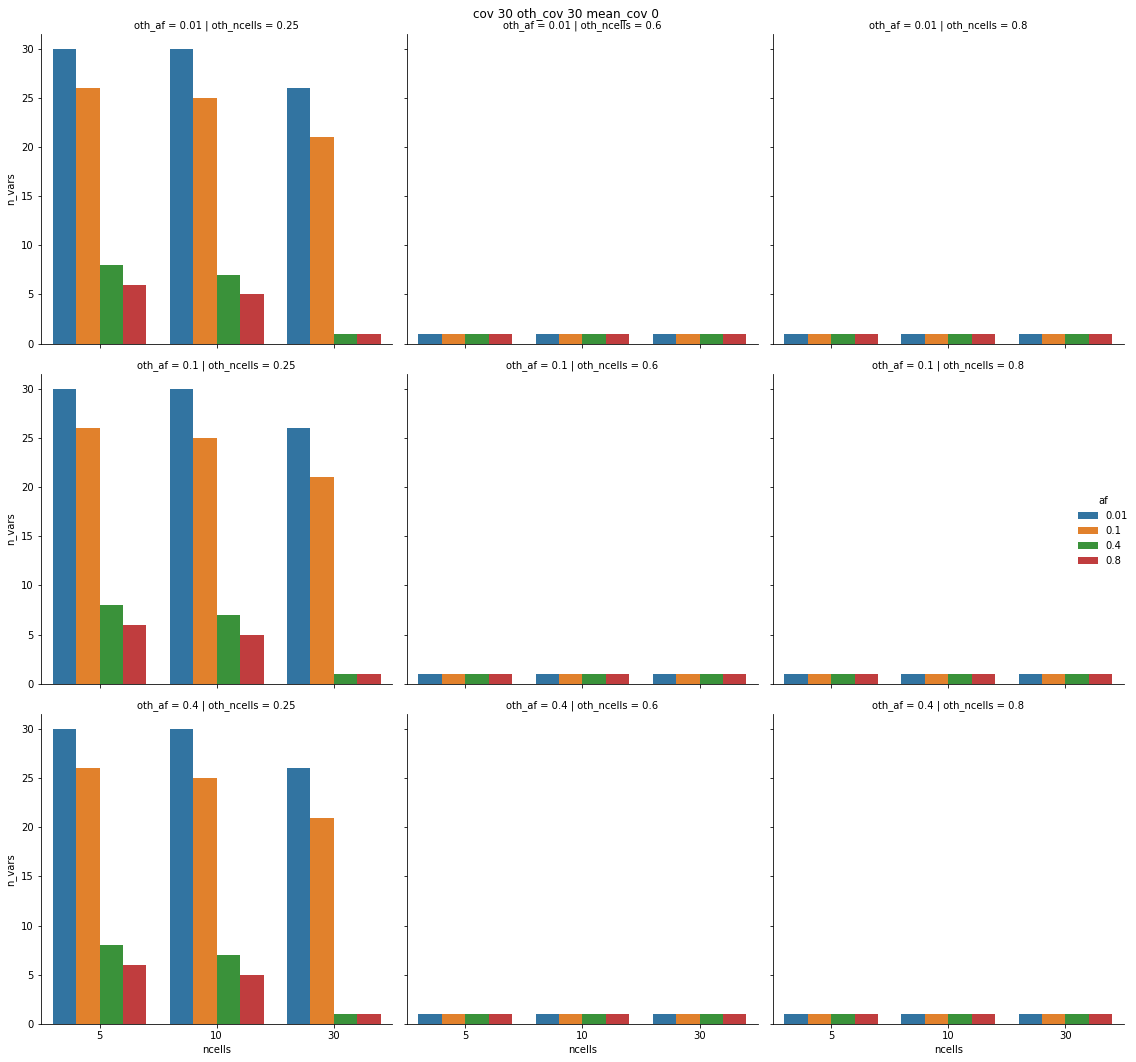

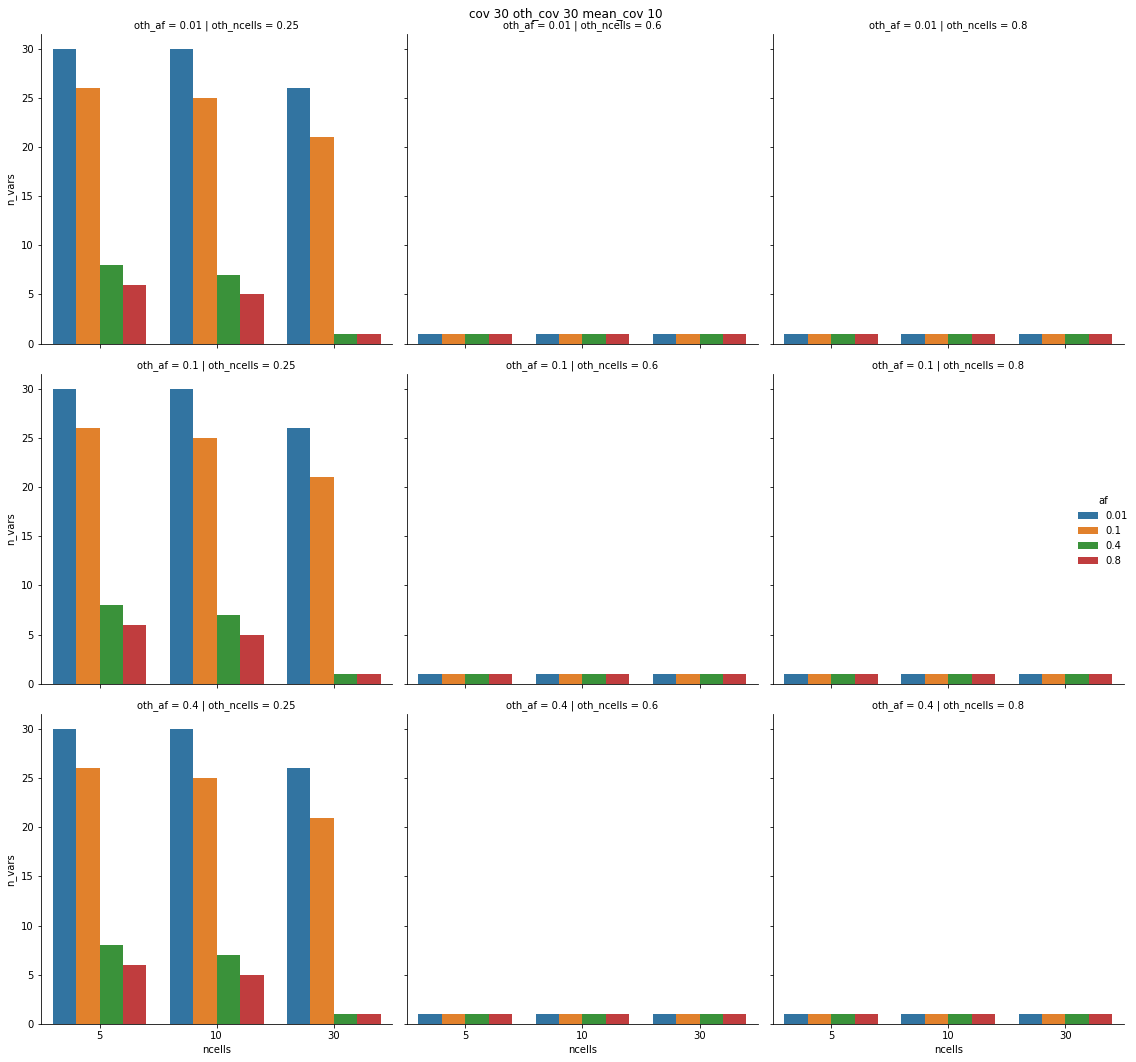

In [11]:
for d in don_dirs: 
    curr_af, curr_cov, curr_cells_meta, curr_variants = load_donor(don_dirs[d])
    if curr_af.shape[0] == 0:
        continue
    curr_cov_name = curr_cov.copy()   
    curr_cov_name.index = "COV-" + curr_cov.index
    curr_af_cov = pd.concat([curr_af, curr_cov_name], verify_integrity=True, sort=False)
    use_small = False

    if use_small: 
        curr_af_cov = pd.concat([curr_af.iloc[:100,:100], curr_cov_name.iloc[:100,:100]], verify_integrity=True, sort=False)
        full_params_df = full_params.iloc[:100]
    else:
        full_params_df = full_params.copy()
    #curr_af_cov.apply(run_per_pos, args=(full_params_df,),expand=True)
    all_passed_vars = defaultdict(list)
    params_results = full_params_df.copy()
    params_results["Variants"] = None
    for ind, val in tqdm(full_params_df.iterrows()):
        # get boolean variant array and keep the ones that are true
        curr_vars = []

        #c_vars_df = pd.DataFrame(index=curr_af.o)
        for c_var in curr_af.columns:
            pos_af = curr_af[c_var]
            pos_cov = curr_cov[c_var]
            isVar = get_vars(val, pos_af, pos_cov)
            if isVar:
                all_passed_vars[tuple(val.values)].append(c_var)
                curr_vars.append(c_var)
        params_results.loc[ind,"Variants"] = ";".join(curr_vars)
        #full_params_df.loc[ind, "Variants"] = curr_vars
    #     if ind>200:
    #         break

    seen_variants = params_results["Variants"].dropna().apply(lambda x: x.split(";"))
    params_results["Variants List"] = seen_variants
    seen_variants = set(sum(list(seen_variants.values), []))
    seen_variants

    params_results["n_vars"] = params_results["Variants List"].apply(lambda x: len(x) if type(x) is list else 0)
    

    ## Save
    params_results.drop("Variants List", axis=1).to_csv(join(outdir, f"donor_{d}_thresh_results.tsv"), sep="\t", index=False)

    plots(params_results,outdir, prefix=f"donor_{d}")

